# 1. Data Loading

### 1.1 Create PyTorch Datasets and DataLoaders

In [1]:
# Load autoreload extension
%load_ext autoreload
# Set autoreload to mode 1
%autoreload 2

# Import required libraries
import os
import numpy as np

import torch
from torch.utils.data import DataLoader
import wandb
from datetime import datetime # Import datetime for timestamp

# Local modules
from utils.data_persistence import load_scalers
from utils.plot_utils import plot_training_history, plot_evaluation_metrics
from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info, save_model, load_model

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Set device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

# ========== Model training hyperparameters =========
PATIENCE = 10
LR = 0.0001
# Debug mode to test code. Set to False for actual training
DEBUG_MODE = False

if DEBUG_MODE:
    # Local debug settings (to check if the code is working)
    # Will only run 10 batches/epoch for 10 epochs
    N_EPOCHS = 10
    BATCH_SIZE = 64
    NUM_WORKERS = 4
else:
    # Remote server settings (to train the model, recommend using Otter lab machine)
    N_EPOCHS = 30
    BATCH_SIZE = 2 ** 13   # = 8192 samples
    NUM_WORKERS = 16

# ================= Wandb settings =============
USE_WANDB = True
WANDB_USERNAME = "tin-hoang"
WANDB_PROJECT = "EEEM073-Solar-Radiation"

# =========== Time series hyperparameters ===========
# Number of timesteps to look back when creating sequences
LOOKBACK = 24

# Choose features to use in modeling
TIME_FEATURES = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos',
            'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
SELECTED_FEATURES = [
    'air_temperature',
    'wind_speed',
    'relative_humidity',
    'cloud_type',      # Categorical feature
    'solar_zenith_angle',
    'clearsky_ghi',
    'total_precipitable_water',
    'surface_albedo',
    'nighttime_mask',  # New field from preprocess_data
    'cld_opd_dcomp',
    'aod'
]
STATIC_FEATURES = ['latitude', 'longitude', 'elevation']
# Target variable
TARGET_VARIABLE = 'ghi'

pvlib not available, using default solar position calculation
Using cuda device


In [2]:
from utils.data_persistence import load_normalized_data

TRAIN_PREPROCESSED_DATA_PATH = "data/processed/train_normalized_20250430_145157.h5"
VAL_PREPROCESSED_DATA_PATH = "data/processed/val_normalized_20250430_145205.h5"
TEST_PREPROCESSED_DATA_PATH = "data/processed/test_normalized_20250430_145205.h5"

# Load sequences
train_data, metadata = load_normalized_data(TRAIN_PREPROCESSED_DATA_PATH)

SCALER_PATH = "data/processed/scalers_20250430_145206.pkl"
scalers = load_scalers(SCALER_PATH)

# Print metadata
print(f"Train set | Metadata: {metadata}")
# Print created time
print(f"Train set | Created time: {metadata['created_time'] if 'created_time' in metadata else 'No created time'}")
# Print raw files
print(f"Train set | Raw files: {metadata['raw_files'] if 'raw_files' in metadata else 'No raw files'}")

# Print data structure and shape
print(f"Train set | Data structure:")
for key, value in train_data.items():
    print(f"  {key} shape: {value.shape}")

Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded 16 scalers from data/processed/scalers_20250430_145206.pkl
Train set | Metadata: {'created_time': '2025-04-30 14:51:57'}
Train set | Created time: 2025-04-30 14:51:57
Train set | Raw files: No raw files
Train set | Data structure:
  air_temperature shape: (70128, 105)
  aod shape: (70128, 105)
  cld_opd_dcomp shape: (70128, 105)
  cld_press_acha shape: (70128, 105)
  cld_reff_dcomp shape: (70128, 105)
  clearsky_ghi shape: (70128, 105)
  cloud_type shape: (70128, 105)
  day_cos shape: (70128,)
  day_sin shape: (70128,)
  dow_cos shape: (70128,)
  dow_sin shape: (70128,)
  elevation shape: (105,)
  ghi shape: (70128, 105)
  hour_cos shape: (70128,)
  hour_sin shape: (70128,)
  latitude shape: (105,)
  longitude shape: (105,)
  month_cos shape: (70128,)
  month_sin shape: (70128,)
  nighttime_mask shape: (70128, 105)
  relative_humidity shape: (70128, 105)
  solar_zenith_angle shape: (70128, 105)
  surf

In [3]:
from utils.timeseriesdataset import TimeSeriesDataset

# Create datasets
train_dataset = TimeSeriesDataset(TRAIN_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                 selected_features=SELECTED_FEATURES, include_target_history=False,
                                 static_features=STATIC_FEATURES)
val_dataset = TimeSeriesDataset(VAL_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                               selected_features=SELECTED_FEATURES, include_target_history=False,
                               static_features=STATIC_FEATURES)
test_dataset = TimeSeriesDataset(TEST_PREPROCESSED_DATA_PATH, lookback=LOOKBACK, target_field=TARGET_VARIABLE,
                                selected_features=SELECTED_FEATURES, include_target_history=False,
                                static_features=STATIC_FEATURES)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

Using time feature keys: ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos']
Using static features: ['latitude', 'longitude', 'elevation']
Not using target field history for autoregression
Loaded normalized data from data/processed/train_normalized_20250430_145157.h5
Loaded normalized data file (1/1): data/processed/train_normalized_20250430_145157.h5
Loaded data with 27 features
Using 11 selected features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total_precipitable_water', 'wind_speed']
Temporal features: ['day_cos', 'day_sin', 'dow_cos', 'dow_sin', 'hour_cos', 'hour_sin', 'month_cos', 'month_sin']
Static features: ['latitude', 'longitude', 'elevation']
Time series features: ['air_temperature', 'aod', 'cld_opd_dcomp', 'clearsky_ghi', 'cloud_type', 'nighttime_mask', 'relative_humidity', 'solar_zenith_angle', 'surface_albedo', 'total

In [4]:
# Get a batch to determine input dimensions
batch = next(iter(train_loader))

# Check sample batch
sample_batch = next(iter(train_loader))
for key, value in sample_batch.items():
    if isinstance(value, torch.Tensor):
        print(f"{key} shape: {value.shape}")
    elif isinstance(value, list):
        print(f"{key} length: {len(value)}")

# Extract dimensions from a batch (more reliable)
temporal_features = batch['temporal_features']
static_features = batch['static_features']
TEMPORAL_FEATURES_SHAPE = list(temporal_features.shape)
STATIC_FEATURES_SHAPE = list(static_features.shape)

# Check if we have 3D temporal features (batch, seq_len, features)
if len(temporal_features.shape) == 3:
    temporal_dim = temporal_features.shape[2]
else:
    # Handle 2D temporal features (batch, features)
    temporal_dim = temporal_features.shape[1]

static_dim = static_features.shape[1]

print(f"  Input dimensions determined from batch:")
print(f"  - Batch temporal_features shape: {TEMPORAL_FEATURES_SHAPE}")
print(f"  - Batch static_features shape: {STATIC_FEATURES_SHAPE}")
print(f"  - Temporal dimension: {temporal_dim}")
print(f"  - Static dimension: {static_dim}")

static_features shape: torch.Size([8192, 3])
target shape: torch.Size([8192])
temporal_features shape: torch.Size([8192, 24, 19])
air_temperature shape: torch.Size([8192, 24])
aod shape: torch.Size([8192, 24])
cld_opd_dcomp shape: torch.Size([8192, 24])
clearsky_ghi shape: torch.Size([8192, 24])
cloud_type shape: torch.Size([8192, 24])
nighttime_mask shape: torch.Size([8192, 24])
relative_humidity shape: torch.Size([8192, 24])
solar_zenith_angle shape: torch.Size([8192, 24])
surface_albedo shape: torch.Size([8192, 24])
total_precipitable_water shape: torch.Size([8192, 24])
wind_speed shape: torch.Size([8192, 24])
time_index_local length: 8192
current_hour_sin shape: torch.Size([8192])
current_hour_cos shape: torch.Size([8192])
current_day_sin shape: torch.Size([8192])
current_day_cos shape: torch.Size([8192])
current_month_sin shape: torch.Size([8192])
current_month_cos shape: torch.Size([8192])
current_dow_sin shape: torch.Size([8192])
current_dow_cos shape: torch.Size([8192])
  Input

## 2. Model Training Setup

## 2.1 Setting parameters

In [5]:
from torchinfo import summary

from utils.training_utils import train_model, evaluate_model
from utils.wandb_utils import is_wandb_enabled, set_wandb_flag, set_keep_run_open
from utils.model_utils import print_model_info

# Enable wandb tracking
set_wandb_flag(USE_WANDB)
# Keep the wandb run open after training to continue logging evaluation plots
set_keep_run_open(True)

True

## 2.2 Setup Experiment Pipeline

In [6]:
def run_experiment_pipeline(model, train_loader, val_loader, test_loader, model_name, epochs=30, patience=5, lr=0.001):
    """
    Run the experiment pipeline for a given model.

    Args:
        model: The model to train.
        train_loader: The training data loader.
        val_loader: The validation data loader.
        test_loader: The test data loader.
        model_name: The name of the model.
        epochs: The number of epochs to train the model.
        patience: The number of epochs to wait before early stopping.
        lr: The learning rate for the model.
    """
    history, val_metrics, test_metrics = None, None, None

    # Get the current config
    CONFIG = {}
    cur_globals = globals().copy()
    for x in cur_globals:
        # Only get the variables that are uppercase and not digits
        if x.upper() == x and not x.startswith('_') and not x == "CONFIG":
            CONFIG[x] = cur_globals[x]

    try:
        print(f"Training {model_name} model...")
        history = train_model(
            model,
            train_loader,
            val_loader,
            model_name=model_name,
            epochs=epochs,
            patience=patience,
            lr=lr,
            target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
            config=CONFIG,
            debug_mode=DEBUG_MODE,
        )
        training_plot = plot_training_history(history, model_name=model_name)

        print(f"\nEvaluating {model_name} model on test set...")
        test_metrics = evaluate_model(
            model,
            test_loader,
            scalers[f'{TARGET_VARIABLE}_scaler'],
            model_name=f"{model_name} - Test"
        )
        test_plot = plot_evaluation_metrics(test_metrics, model_name=f"{model_name} - Test")

        # ========== Save Best Model Checkpoint ===========
        checkpoint_dir = "checkpoints"
        os.makedirs(checkpoint_dir, exist_ok=True)

        # Generate timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Construct filename with timestamp and directory
        model_filename = f"{model_name}_best_{timestamp}.pt"
        model_path = os.path.join(checkpoint_dir, model_filename)

        # Combine time keys and selected features for the complete temporal feature set
        all_temporal_features = TIME_FEATURES + SELECTED_FEATURES

        # Save the model with metadata using the new save_model function
        save_model(
            model=model,
            filepath=model_path,
            metadata={
                "model_name": model_name,
                "timestamp": timestamp,
                "train_metrics": {
                    "final_train_loss": history["train_loss"][-1] if history and "train_loss" in history else None,
                    "final_train_mae": history["train_mae"][-1] if history and "train_mae" in history else None,
                    "final_val_loss": history["val_loss"][-1] if history and "val_loss" in history else None,
                    "final_val_mae": history["val_mae"][-1] if history and "val_mae" in history else None,
                },
                "test_metrics": {
                    "mse": test_metrics["mse"] if test_metrics else None,
                    "rmse": test_metrics["rmse"] if test_metrics else None,
                    "mae": test_metrics["mae"] if test_metrics else None,
                    "r2": test_metrics["r2"] if test_metrics else None,
                }
            },
            temporal_features=all_temporal_features,
            static_features=STATIC_FEATURES,
            time_feature_keys=TIME_FEATURES,
            config=CONFIG
        )

        print(f"Best model saved to {model_path}")

        # Log saved model path to wandb if enabled
        if is_wandb_enabled():
            wandb.save(model_path)
            print(f"Saved model checkpoint logged to wandb: {model_path}")
            wandb.log({"plots/history_plot": wandb.Image(training_plot)})
            wandb.log({"plots/predictions_plot": wandb.Image(test_plot)})

    finally:
        # Finish wandb run if it's still open
        if is_wandb_enabled():
            wandb.finish()

        # Clear GPU memory
        torch.cuda.empty_cache()

    return history, val_metrics, test_metrics

# 3. Model Experiments

### 3.1 Temporal Convolutional Networks (TCN) Model

TCNs are specialized convolutional architectures for sequence modeling that combine the best of CNNs and RNNs. The key features include:

- **Causal Convolutions**: Each output only depends on current and past inputs.
- **Dilated Convolutions**: Captures larger effective history with fewer parameters.
- **Residual Connections**: Helps with training deep networks and information flow.

TCNs can capture long-range patterns in time series data efficiently, making them suitable for solar radiation forecasting where both short-term weather fluctuations and longer-term patterns matter.

In [7]:
from models.tcn import TCNModel

# Create TCN model
tcn_model = TCNModel(
    input_dim=temporal_dim,
    static_dim=static_dim,
    num_channels=[64, 128, 128, 64],  # Number of channels in each layer
    kernel_size=3,                    # Size of the convolutional kernel
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(tcn_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TCNModel
Total parameters: 267,873
Trainable parameters: 267,873
Non-trainable parameters: 0

Model structure:
TCNModel(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(19, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(2,))
          (5): Chomp1d()
          (6): Re

/user/HS402/th01167/.venv/master/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


Training TCN model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for TCN


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tin-hoang to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation TCN (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 5137.60, RMSE: 71.68, MAE: 47.48, R²: 0.9468, WAPE: 20.34%
  Daytime:  MSE: 9249.91, RMSE: 96.18, MAE: 69.70, R²: 0.8899, WAPE: 14.89%
  Nighttime: MSE: 1049.49, RMSE: 32.40, MAE: 25.40, R²: -405.7048, WAPE: 8037.11%
  Inference Speed: 5810344.85 samples/sec, 0.0002 ms/sample
  Total time: 0.0155 sec for 90112 samples
Epoch 1/30 | Train Loss: 40542.4961, Train MAE: 137.2114 | Val Loss: 5137.5991, Val MAE: 47.4809 | LR: 0.000100



Validation TCN (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3960.21, RMSE: 62.93, MAE: 41.12, R²: 0.9590, WAPE: 17.61%
  Daytime:  MSE: 7269.79, RMSE: 85.26, MAE: 62.28, R²: 0.9135, WAPE: 13.31%
  Nighttime: MSE: 670.10, RMSE: 25.89, MAE: 20.09, R²: -258.6798, WAPE: 6357.43%
  Inference Speed: 5871999.53 samples/sec, 0.0002 ms/sample
  Total time: 0.0153 sec for 90112 samples
Epoch 2/30 | Train Loss: 8639.0859, Train MAE: 65.4878 | Val Loss: 3960.2053, Val MAE: 41.1230 | LR: 0.000100



Validation TCN (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3337.55, RMSE: 57.77, MAE: 34.98, R²: 0.9654, WAPE: 14.98%
  Daytime:  MSE: 6330.12, RMSE: 79.56, MAE: 55.30, R²: 0.9247, WAPE: 11.82%
  Nighttime: MSE: 362.58, RMSE: 19.04, MAE: 14.77, R²: -139.5108, WAPE: 4675.11%
  Inference Speed: 4182422.12 samples/sec, 0.0002 ms/sample
  Total time: 0.0215 sec for 90112 samples
Epoch 3/30 | Train Loss: 5565.3472, Train MAE: 48.5024 | Val Loss: 3337.5469, Val MAE: 34.9786 | LR: 0.000100



Validation TCN (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 3100.29, RMSE: 55.68, MAE: 31.24, R²: 0.9679, WAPE: 13.38%
  Daytime:  MSE: 6098.91, RMSE: 78.10, MAE: 53.51, R²: 0.9274, WAPE: 11.43%
  Nighttime: MSE: 119.32, RMSE: 10.92, MAE: 9.10, R²: -45.2377, WAPE: 2878.50%
  Inference Speed: 7249307.06 samples/sec, 0.0001 ms/sample
  Total time: 0.0124 sec for 90112 samples
Epoch 4/30 | Train Loss: 4673.6025, Train MAE: 41.2282 | Val Loss: 3100.2859, Val MAE: 31.2357 | LR: 0.000100



Validation TCN (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 2968.01, RMSE: 54.48, MAE: 28.29, R²: 0.9693, WAPE: 12.12%
  Daytime:  MSE: 5907.70, RMSE: 76.86, MAE: 50.87, R²: 0.9297, WAPE: 10.87%
  Nighttime: MSE: 45.62, RMSE: 6.75, MAE: 5.85, R²: -16.6793, WAPE: 1851.86%
  Inference Speed: 6705052.81 samples/sec, 0.0001 ms/sample
  Total time: 0.0134 sec for 90112 samples
Epoch 5/30 | Train Loss: 4322.5854, Train MAE: 37.9920 | Val Loss: 2968.0098, Val MAE: 28.2930 | LR: 0.000100



Validation TCN (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 2905.50, RMSE: 53.90, MAE: 27.23, R²: 0.9699, WAPE: 11.66%
  Daytime:  MSE: 5795.81, RMSE: 76.13, MAE: 49.91, R²: 0.9310, WAPE: 10.66%
  Nighttime: MSE: 32.21, RMSE: 5.67, MAE: 4.69, R²: -11.4805, WAPE: 1483.48%
  Inference Speed: 6313385.26 samples/sec, 0.0002 ms/sample
  Total time: 0.0143 sec for 90112 samples
Epoch 6/30 | Train Loss: 4143.1973, Train MAE: 36.6912 | Val Loss: 2905.5002, Val MAE: 27.2341 | LR: 0.000100



Validation TCN (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 2858.91, RMSE: 53.47, MAE: 25.62, R²: 0.9704, WAPE: 10.97%
  Daytime:  MSE: 5721.53, RMSE: 75.64, MAE: 48.81, R²: 0.9319, WAPE: 10.43%
  Nighttime: MSE: 13.14, RMSE: 3.62, MAE: 2.57, R²: -4.0920, WAPE: 812.19%
  Inference Speed: 6607757.51 samples/sec, 0.0002 ms/sample
  Total time: 0.0136 sec for 90112 samples
Epoch 7/30 | Train Loss: 4024.9026, Train MAE: 36.0378 | Val Loss: 2858.9092, Val MAE: 25.6178 | LR: 0.000100



Validation TCN (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2844.65, RMSE: 53.34, MAE: 25.44, R²: 0.9705, WAPE: 10.90%
  Daytime:  MSE: 5697.20, RMSE: 75.48, MAE: 49.03, R²: 0.9322, WAPE: 10.47%
  Nighttime: MSE: 8.90, RMSE: 2.98, MAE: 2.00, R²: -2.4478, WAPE: 632.40%
  Inference Speed: 4416367.21 samples/sec, 0.0002 ms/sample
  Total time: 0.0204 sec for 90112 samples
Epoch 8/30 | Train Loss: 3935.3625, Train MAE: 35.6207 | Val Loss: 2844.6511, Val MAE: 25.4427 | LR: 0.000100



Validation TCN (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2833.00, RMSE: 53.23, MAE: 25.09, R²: 0.9707, WAPE: 10.74%
  Daytime:  MSE: 5674.27, RMSE: 75.33, MAE: 48.03, R²: 0.9325, WAPE: 10.26%
  Nighttime: MSE: 8.44, RMSE: 2.91, MAE: 2.28, R²: -2.2720, WAPE: 722.25%
  Inference Speed: 6112942.50 samples/sec, 0.0002 ms/sample
  Total time: 0.0147 sec for 90112 samples
Epoch 9/30 | Train Loss: 3856.8594, Train MAE: 35.2910 | Val Loss: 2832.9961, Val MAE: 25.0871 | LR: 0.000100



Validation TCN (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2812.35, RMSE: 53.03, MAE: 24.85, R²: 0.9709, WAPE: 10.64%
  Daytime:  MSE: 5638.07, RMSE: 75.09, MAE: 48.49, R²: 0.9329, WAPE: 10.36%
  Nighttime: MSE: 3.26, RMSE: 1.81, MAE: 1.34, R²: -0.2636, WAPE: 425.54%
  Inference Speed: 3624062.69 samples/sec, 0.0003 ms/sample
  Total time: 0.0249 sec for 90112 samples
Epoch 10/30 | Train Loss: 3801.4827, Train MAE: 35.0685 | Val Loss: 2812.3503, Val MAE: 24.8462 | LR: 0.000100



Validation TCN (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2815.80, RMSE: 53.06, MAE: 24.41, R²: 0.9708, WAPE: 10.45%
  Daytime:  MSE: 5645.88, RMSE: 75.14, MAE: 47.72, R²: 0.9328, WAPE: 10.20%
  Nighttime: MSE: 2.38, RMSE: 1.54, MAE: 1.23, R²: 0.0778, WAPE: 389.45%
  Inference Speed: 4148952.46 samples/sec, 0.0002 ms/sample
  Total time: 0.0217 sec for 90112 samples
Epoch 11/30 | Train Loss: 3752.8088, Train MAE: 34.8838 | Val Loss: 2815.7983, Val MAE: 24.4061 | LR: 0.000100



Validation TCN (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2815.59, RMSE: 53.06, MAE: 24.57, R²: 0.9708, WAPE: 10.52%
  Daytime:  MSE: 5646.06, RMSE: 75.14, MAE: 48.32, R²: 0.9328, WAPE: 10.32%
  Nighttime: MSE: 1.78, RMSE: 1.33, MAE: 0.96, R²: 0.3106, WAPE: 302.58%
  Inference Speed: 6339966.82 samples/sec, 0.0002 ms/sample
  Total time: 0.0142 sec for 90112 samples
Epoch 12/30 | Train Loss: 3715.9927, Train MAE: 34.7454 | Val Loss: 2815.5874, Val MAE: 24.5667 | LR: 0.000100



Validation TCN (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2803.69, RMSE: 52.95, MAE: 24.40, R²: 0.9710, WAPE: 10.45%
  Daytime:  MSE: 5620.45, RMSE: 74.97, MAE: 47.50, R²: 0.9331, WAPE: 10.15%
  Nighttime: MSE: 3.52, RMSE: 1.88, MAE: 1.43, R²: -0.3640, WAPE: 452.78%
  Inference Speed: 5203369.11 samples/sec, 0.0002 ms/sample
  Total time: 0.0173 sec for 90112 samples
Epoch 13/30 | Train Loss: 3686.2522, Train MAE: 34.6573 | Val Loss: 2803.6931, Val MAE: 24.3992 | LR: 0.000100



Validation TCN (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2855.85, RMSE: 53.44, MAE: 25.51, R²: 0.9704, WAPE: 10.93%
  Daytime:  MSE: 5725.53, RMSE: 75.67, MAE: 49.63, R²: 0.9319, WAPE: 10.60%
  Nighttime: MSE: 3.05, RMSE: 1.75, MAE: 1.54, R²: -0.1823, WAPE: 487.17%
  Inference Speed: 3849830.63 samples/sec, 0.0003 ms/sample
  Total time: 0.0234 sec for 90112 samples
Epoch 14/30 | Train Loss: 3659.0120, Train MAE: 34.5786 | Val Loss: 2855.8455, Val MAE: 25.5127 | LR: 0.000100



Validation TCN (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2806.84, RMSE: 52.98, MAE: 24.59, R²: 0.9709, WAPE: 10.53%
  Daytime:  MSE: 5626.93, RMSE: 75.01, MAE: 47.72, R²: 0.9330, WAPE: 10.20%
  Nighttime: MSE: 3.36, RMSE: 1.83, MAE: 1.59, R²: -0.3010, WAPE: 502.75%
  Inference Speed: 7430008.89 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 15/30 | Train Loss: 3635.3604, Train MAE: 34.4981 | Val Loss: 2806.8435, Val MAE: 24.5861 | LR: 0.000100



Validation TCN (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2824.20, RMSE: 53.14, MAE: 24.75, R²: 0.9708, WAPE: 10.60%
  Daytime:  MSE: 5661.17, RMSE: 75.24, MAE: 47.85, R²: 0.9326, WAPE: 10.22%
  Nighttime: MSE: 3.92, RMSE: 1.98, MAE: 1.80, R²: -0.5207, WAPE: 568.09%
  Inference Speed: 5926508.01 samples/sec, 0.0002 ms/sample
  Total time: 0.0152 sec for 90112 samples
Epoch 16/30 | Train Loss: 3614.8330, Train MAE: 34.4526 | Val Loss: 2824.1997, Val MAE: 24.7548 | LR: 0.000100



Validation TCN (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2829.82, RMSE: 53.20, MAE: 24.97, R²: 0.9707, WAPE: 10.70%
  Daytime:  MSE: 5673.63, RMSE: 75.32, MAE: 48.67, R²: 0.9325, WAPE: 10.40%
  Nighttime: MSE: 2.75, RMSE: 1.66, MAE: 1.42, R²: -0.0667, WAPE: 449.34%
  Inference Speed: 4071190.60 samples/sec, 0.0002 ms/sample
  Total time: 0.0221 sec for 90112 samples
Epoch 17/30 | Train Loss: 3595.4731, Train MAE: 34.4035 | Val Loss: 2829.8232, Val MAE: 24.9737 | LR: 0.000100



Validation TCN (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2815.05, RMSE: 53.06, MAE: 24.90, R²: 0.9709, WAPE: 10.66%
  Daytime:  MSE: 5642.99, RMSE: 75.12, MAE: 48.24, R²: 0.9328, WAPE: 10.31%
  Nighttime: MSE: 3.75, RMSE: 1.94, MAE: 1.69, R²: -0.4551, WAPE: 535.59%
  Inference Speed: 7433516.02 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 18/30 | Train Loss: 3576.6770, Train MAE: 34.3658 | Val Loss: 2815.0510, Val MAE: 24.8952 | LR: 0.000100



Validation TCN (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2802.70, RMSE: 52.94, MAE: 23.95, R²: 0.9710, WAPE: 10.26%
  Daytime:  MSE: 5618.98, RMSE: 74.96, MAE: 46.56, R²: 0.9331, WAPE: 9.95%
  Nighttime: MSE: 2.99, RMSE: 1.73, MAE: 1.47, R²: -0.1584, WAPE: 464.04%
  Inference Speed: 5278435.87 samples/sec, 0.0002 ms/sample
  Total time: 0.0171 sec for 90112 samples
Epoch 19/30 | Train Loss: 3560.1699, Train MAE: 34.2971 | Val Loss: 2802.6963, Val MAE: 23.9460 | LR: 0.000100



Validation TCN (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2811.70, RMSE: 53.03, MAE: 24.37, R²: 0.9709, WAPE: 10.44%
  Daytime:  MSE: 5637.32, RMSE: 75.08, MAE: 47.46, R²: 0.9329, WAPE: 10.14%
  Nighttime: MSE: 2.72, RMSE: 1.65, MAE: 1.41, R²: -0.0533, WAPE: 445.86%
  Inference Speed: 6020822.33 samples/sec, 0.0002 ms/sample
  Total time: 0.0150 sec for 90112 samples
Epoch 20/30 | Train Loss: 3542.1887, Train MAE: 34.2480 | Val Loss: 2811.7014, Val MAE: 24.3662 | LR: 0.000100



Validation TCN (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2818.49, RMSE: 53.09, MAE: 24.61, R²: 0.9708, WAPE: 10.54%
  Daytime:  MSE: 5650.96, RMSE: 75.17, MAE: 47.93, R²: 0.9328, WAPE: 10.24%
  Nighttime: MSE: 2.69, RMSE: 1.64, MAE: 1.44, R²: -0.0407, WAPE: 454.20%
  Inference Speed: 6064196.68 samples/sec, 0.0002 ms/sample
  Total time: 0.0149 sec for 90112 samples
Epoch 21/30 | Train Loss: 3533.2727, Train MAE: 34.2270 | Val Loss: 2818.4866, Val MAE: 24.6133 | LR: 0.000100



Validation TCN (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2797.86, RMSE: 52.89, MAE: 24.30, R²: 0.9710, WAPE: 10.41%
  Daytime:  MSE: 5610.91, RMSE: 74.91, MAE: 47.95, R²: 0.9332, WAPE: 10.24%
  Nighttime: MSE: 1.38, RMSE: 1.17, MAE: 0.78, R²: 0.4671, WAPE: 248.33%
  Inference Speed: 3312014.18 samples/sec, 0.0003 ms/sample
  Total time: 0.0272 sec for 90112 samples
Epoch 22/30 | Train Loss: 3514.7288, Train MAE: 34.1716 | Val Loss: 2797.8638, Val MAE: 24.2960 | LR: 0.000100



Validation TCN (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2827.90, RMSE: 53.18, MAE: 24.21, R²: 0.9707, WAPE: 10.37%
  Daytime:  MSE: 5671.67, RMSE: 75.31, MAE: 47.98, R²: 0.9325, WAPE: 10.25%
  Nighttime: MSE: 0.87, RMSE: 0.93, MAE: 0.57, R²: 0.6619, WAPE: 181.04%
  Inference Speed: 4592710.64 samples/sec, 0.0002 ms/sample
  Total time: 0.0196 sec for 90112 samples
Epoch 23/30 | Train Loss: 3499.1438, Train MAE: 34.1266 | Val Loss: 2827.9026, Val MAE: 24.2070 | LR: 0.000100



Validation TCN (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2814.90, RMSE: 53.06, MAE: 24.60, R²: 0.9709, WAPE: 10.54%
  Daytime:  MSE: 5645.38, RMSE: 75.14, MAE: 48.70, R²: 0.9328, WAPE: 10.41%
  Nighttime: MSE: 1.08, RMSE: 1.04, MAE: 0.65, R²: 0.5799, WAPE: 205.04%
  Inference Speed: 3100855.88 samples/sec, 0.0003 ms/sample
  Total time: 0.0291 sec for 90112 samples
Epoch 24/30 | Train Loss: 3489.4089, Train MAE: 34.0956 | Val Loss: 2814.8999, Val MAE: 24.6047 | LR: 0.000100



Validation TCN (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2827.65, RMSE: 53.18, MAE: 24.67, R²: 0.9707, WAPE: 10.57%
  Daytime:  MSE: 5669.29, RMSE: 75.29, MAE: 47.96, R²: 0.9325, WAPE: 10.25%
  Nighttime: MSE: 2.73, RMSE: 1.65, MAE: 1.52, R²: -0.0584, WAPE: 480.73%
  Inference Speed: 6846801.24 samples/sec, 0.0001 ms/sample
  Total time: 0.0132 sec for 90112 samples
Epoch 25/30 | Train Loss: 3477.0059, Train MAE: 34.0680 | Val Loss: 2827.6455, Val MAE: 24.6709 | LR: 0.000100



Validation TCN (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2823.81, RMSE: 53.14, MAE: 24.42, R²: 0.9708, WAPE: 10.46%
  Daytime:  MSE: 5662.96, RMSE: 75.25, MAE: 48.00, R²: 0.9326, WAPE: 10.26%
  Nighttime: MSE: 1.38, RMSE: 1.17, MAE: 0.97, R²: 0.4665, WAPE: 307.96%
  Inference Speed: 4755493.62 samples/sec, 0.0002 ms/sample
  Total time: 0.0189 sec for 90112 samples
Epoch 26/30 | Train Loss: 3464.9326, Train MAE: 34.0222 | Val Loss: 2823.8098, Val MAE: 24.4178 | LR: 0.000100



Validation TCN (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2862.76, RMSE: 53.50, MAE: 25.01, R²: 0.9704, WAPE: 10.71%
  Daytime:  MSE: 5740.23, RMSE: 75.76, MAE: 48.83, R²: 0.9317, WAPE: 10.43%
  Nighttime: MSE: 2.23, RMSE: 1.49, MAE: 1.32, R²: 0.1342, WAPE: 417.82%
  Inference Speed: 6643531.00 samples/sec, 0.0002 ms/sample
  Total time: 0.0136 sec for 90112 samples
Epoch 27/30 | Train Loss: 3449.0752, Train MAE: 33.9675 | Val Loss: 2862.7634, Val MAE: 25.0055 | LR: 0.000100



Validation TCN (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 2829.24, RMSE: 53.19, MAE: 23.91, R²: 0.9707, WAPE: 10.24%
  Daytime:  MSE: 5674.26, RMSE: 75.33, MAE: 47.34, R²: 0.9325, WAPE: 10.11%
  Nighttime: MSE: 0.97, RMSE: 0.98, MAE: 0.62, R²: 0.6256, WAPE: 195.55%
  Inference Speed: 6839738.72 samples/sec, 0.0001 ms/sample
  Total time: 0.0132 sec for 90112 samples
Epoch 28/30 | Train Loss: 3440.3884, Train MAE: 33.9413 | Val Loss: 2829.2393, Val MAE: 23.9097 | LR: 0.000050



Validation TCN (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2814.02, RMSE: 53.05, MAE: 24.20, R²: 0.9709, WAPE: 10.36%
  Daytime:  MSE: 5641.01, RMSE: 75.11, MAE: 46.78, R²: 0.9329, WAPE: 9.99%
  Nighttime: MSE: 3.67, RMSE: 1.92, MAE: 1.76, R²: -0.4212, WAPE: 555.83%
  Inference Speed: 6952214.15 samples/sec, 0.0001 ms/sample
  Total time: 0.0130 sec for 90112 samples
Epoch 29/30 | Train Loss: 3412.7446, Train MAE: 33.8120 | Val Loss: 2814.0171, Val MAE: 24.2000 | LR: 0.000050



Validation TCN (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2848.09, RMSE: 53.37, MAE: 24.78, R²: 0.9705, WAPE: 10.61%
  Daytime:  MSE: 5710.76, RMSE: 75.57, MAE: 48.36, R²: 0.9320, WAPE: 10.33%
  Nighttime: MSE: 2.27, RMSE: 1.51, MAE: 1.34, R²: 0.1215, WAPE: 424.08%
  Inference Speed: 5175297.09 samples/sec, 0.0002 ms/sample
  Total time: 0.0174 sec for 90112 samples
Epoch 30/30 | Train Loss: 3407.0210, Train MAE: 33.7955 | Val Loss: 2848.0896, Val MAE: 24.7783 | LR: 0.000050
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


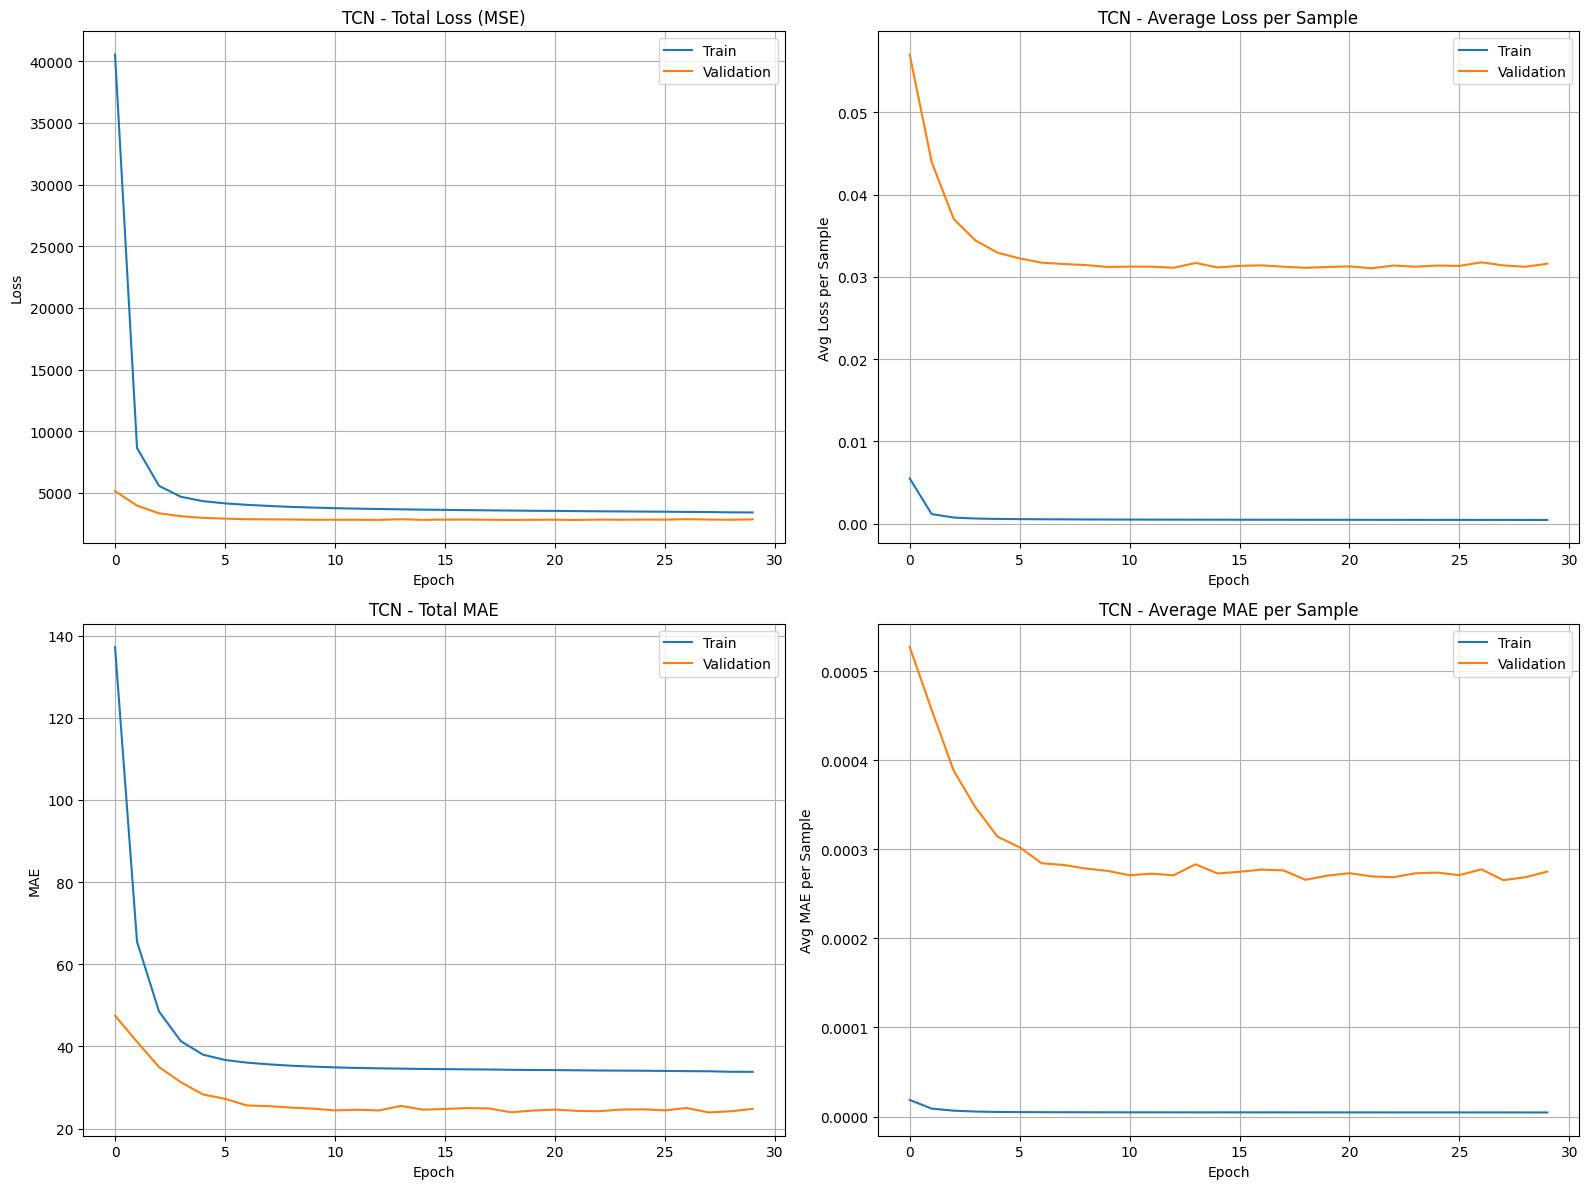


Evaluating TCN model on test set...

TCN - Test Evaluation Metrics:
  Overall:  MSE: 2779.05, RMSE: 52.72, MAE: 25.05, R²: 0.9712, WAPE: 10.83%
  Daytime:  MSE: 5573.39, RMSE: 74.66, MAE: 48.91, R²: 0.9349, WAPE: 10.54%
  Nighttime: MSE: 2.26, RMSE: 1.50, MAE: 1.33, R²: 0.0983, WAPE: 429.58%
  Inference Speed: 6108990.32 samples/sec, 0.0002 ms/sample
  Total time: 0.0148 sec for 90112 samples
Model saved to checkpoints/TCN_best_20250430_162538.pt with metadata.
Best model saved to checkpoints/TCN_best_20250430_162538.pt
Saved model checkpoint logged to wandb: checkpoints/TCN_best_20250430_162538.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,███████████████████████████▁▁▁
train/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


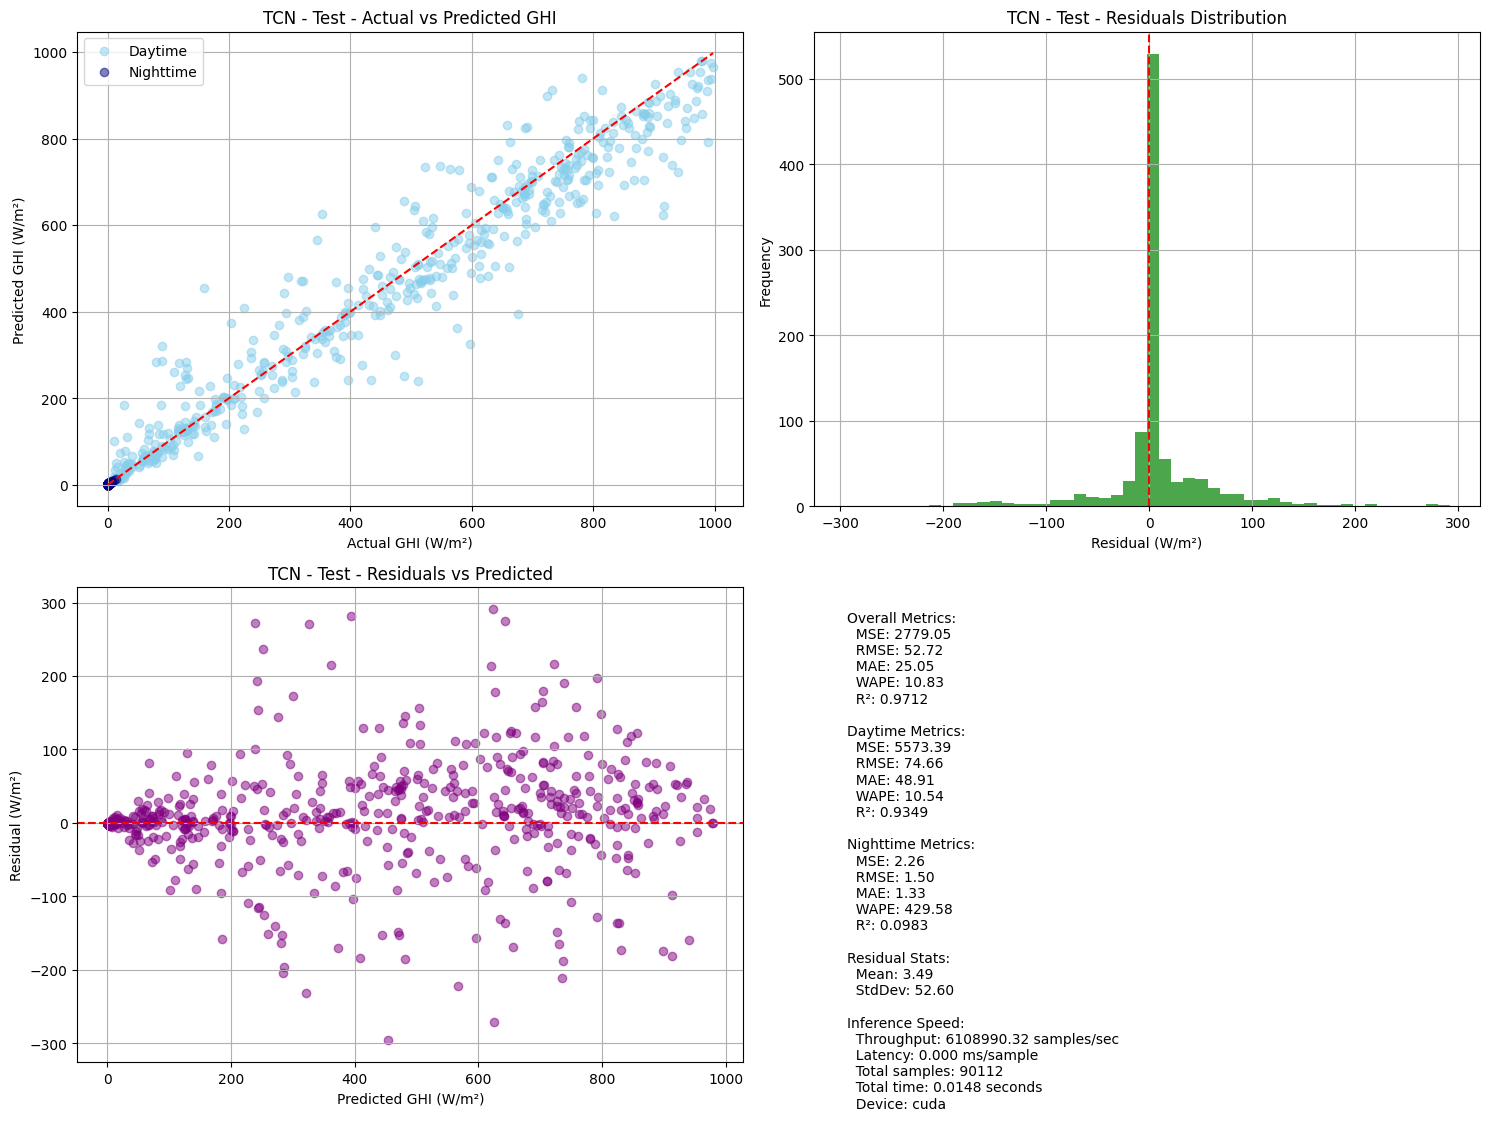

In [8]:
model_name = "TCN"

# Train the TCN model
tcn_history, tcn_val_metrics, tcn_test_metrics = run_experiment_pipeline(
    tcn_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.2 Transformer Model

Transformers revolutionized natural language processing and have been adapted for time series forecasting with impressive results. Their key advantages include:

- **Self-Attention Mechanism**: Allows the model to weight the importance of different input time steps dynamically.
- **Parallelization**: Can process the entire sequence in parallel, unlike RNNs.
- **Long-range Dependencies**: Captures dependencies at arbitrary distances in the sequence.

For solar forecasting, Transformers can identify complex temporal patterns across different time scales and account for both short-term and long-term relationships in the weather and solar data.

In [9]:
from models.transformer import TransformerModel

# Create Transformer model
transformer_model = TransformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Transformer model dimension
    nhead=8,                          # Number of attention heads
    num_layers=4,                     # Number of transformer layers
    dim_feedforward=512,              # Dimension of feedforward network
    dropout=0.2,                      # Dropout rate
).to(device)

# Print the model
print_model_info(transformer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: TransformerModel
Total parameters: 808,705
Trainable parameters: 808,705
Non-trainable parameters: 0

Model structure:
TransformerModel(
  (input_projection): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): D

Training Transformer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Transformer


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation Transformer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 4127.23, RMSE: 64.24, MAE: 38.78, R²: 0.9573, WAPE: 16.61%
  Daytime:  MSE: 7671.42, RMSE: 87.59, MAE: 58.14, R²: 0.9087, WAPE: 12.42%
  Nighttime: MSE: 603.90, RMSE: 24.57, MAE: 19.54, R²: -233.0274, WAPE: 6183.20%
  Inference Speed: 2822344.77 samples/sec, 0.0004 ms/sample
  Total time: 0.0319 sec for 90112 samples
Epoch 1/30 | Train Loss: 34513.2656, Train MAE: 125.2581 | Val Loss: 4127.2280, Val MAE: 38.7837 | LR: 0.000100



Validation Transformer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3625.93, RMSE: 60.22, MAE: 36.88, R²: 0.9625, WAPE: 15.79%
  Daytime:  MSE: 6843.07, RMSE: 82.72, MAE: 54.01, R²: 0.9186, WAPE: 11.54%
  Nighttime: MSE: 427.72, RMSE: 20.68, MAE: 19.85, R²: -164.7533, WAPE: 6280.63%
  Inference Speed: 6217831.77 samples/sec, 0.0002 ms/sample
  Total time: 0.0145 sec for 90112 samples
Epoch 2/30 | Train Loss: 8460.7471, Train MAE: 60.6545 | Val Loss: 3625.9297, Val MAE: 36.8779 | LR: 0.000100



Validation Transformer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 3141.13, RMSE: 56.05, MAE: 31.57, R²: 0.9675, WAPE: 13.52%
  Daytime:  MSE: 6129.15, RMSE: 78.29, MAE: 50.70, R²: 0.9271, WAPE: 10.83%
  Nighttime: MSE: 170.70, RMSE: 13.07, MAE: 12.55, R²: -65.1525, WAPE: 3973.22%
  Inference Speed: 7683304.64 samples/sec, 0.0001 ms/sample
  Total time: 0.0117 sec for 90112 samples
Epoch 3/30 | Train Loss: 6438.8604, Train MAE: 50.5225 | Val Loss: 3141.1313, Val MAE: 31.5723 | LR: 0.000100



Validation Transformer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 2946.56, RMSE: 54.28, MAE: 29.47, R²: 0.9695, WAPE: 12.62%
  Daytime:  MSE: 5812.91, RMSE: 76.24, MAE: 49.55, R²: 0.9308, WAPE: 10.59%
  Nighttime: MSE: 97.09, RMSE: 9.85, MAE: 9.51, R²: -36.6263, WAPE: 3009.94%
  Inference Speed: 7804355.28 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 4/30 | Train Loss: 5700.7563, Train MAE: 46.5266 | Val Loss: 2946.5647, Val MAE: 29.4720 | LR: 0.000100



Validation Transformer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 2916.08, RMSE: 54.00, MAE: 25.78, R²: 0.9698, WAPE: 11.04%
  Daytime:  MSE: 5829.03, RMSE: 76.35, MAE: 47.81, R²: 0.9306, WAPE: 10.21%
  Nighttime: MSE: 20.28, RMSE: 4.50, MAE: 3.88, R²: -6.8602, WAPE: 1227.81%
  Inference Speed: 6479635.21 samples/sec, 0.0002 ms/sample
  Total time: 0.0139 sec for 90112 samples
Epoch 5/30 | Train Loss: 5322.9673, Train MAE: 44.5554 | Val Loss: 2916.0818, Val MAE: 25.7776 | LR: 0.000100



Validation Transformer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 2863.73, RMSE: 53.51, MAE: 25.23, R²: 0.9704, WAPE: 10.80%
  Daytime:  MSE: 5738.55, RMSE: 75.75, MAE: 49.66, R²: 0.9317, WAPE: 10.61%
  Nighttime: MSE: 5.84, RMSE: 2.42, MAE: 0.94, R²: -1.2637, WAPE: 296.38%
  Inference Speed: 6652652.07 samples/sec, 0.0002 ms/sample
  Total time: 0.0135 sec for 90112 samples
Epoch 6/30 | Train Loss: 5112.8960, Train MAE: 43.7622 | Val Loss: 2863.7349, Val MAE: 25.2271 | LR: 0.000100



Validation Transformer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 2868.03, RMSE: 53.55, MAE: 25.59, R²: 0.9703, WAPE: 10.96%
  Daytime:  MSE: 5736.98, RMSE: 75.74, MAE: 48.54, R²: 0.9317, WAPE: 10.37%
  Nighttime: MSE: 15.96, RMSE: 4.00, MAE: 2.78, R²: -5.1857, WAPE: 880.57%
  Inference Speed: 5118665.23 samples/sec, 0.0002 ms/sample
  Total time: 0.0176 sec for 90112 samples
Epoch 7/30 | Train Loss: 4971.4185, Train MAE: 43.2485 | Val Loss: 2868.0251, Val MAE: 25.5929 | LR: 0.000100



Validation Transformer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2971.74, RMSE: 54.51, MAE: 27.81, R²: 0.9692, WAPE: 11.91%
  Daytime:  MSE: 5946.96, RMSE: 77.12, MAE: 53.49, R²: 0.9292, WAPE: 11.43%
  Nighttime: MSE: 14.03, RMSE: 3.75, MAE: 2.27, R²: -4.4373, WAPE: 719.38%
  Inference Speed: 7552798.09 samples/sec, 0.0001 ms/sample
  Total time: 0.0119 sec for 90112 samples
Epoch 8/30 | Train Loss: 4870.3384, Train MAE: 42.9670 | Val Loss: 2971.7368, Val MAE: 27.8084 | LR: 0.000100



Validation Transformer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2997.15, RMSE: 54.75, MAE: 28.15, R²: 0.9690, WAPE: 12.06%
  Daytime:  MSE: 6002.36, RMSE: 77.47, MAE: 53.95, R²: 0.9286, WAPE: 11.53%
  Nighttime: MSE: 9.64, RMSE: 3.10, MAE: 2.50, R²: -2.7343, WAPE: 791.90%
  Inference Speed: 5834202.21 samples/sec, 0.0002 ms/sample
  Total time: 0.0154 sec for 90112 samples
Epoch 9/30 | Train Loss: 4788.9917, Train MAE: 42.7174 | Val Loss: 2997.1533, Val MAE: 28.1495 | LR: 0.000100



Validation Transformer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2822.73, RMSE: 53.13, MAE: 25.52, R²: 0.9708, WAPE: 10.93%
  Daytime:  MSE: 5655.01, RMSE: 75.20, MAE: 48.83, R²: 0.9327, WAPE: 10.43%
  Nighttime: MSE: 7.11, RMSE: 2.67, MAE: 2.35, R²: -1.7566, WAPE: 745.23%
  Inference Speed: 5707166.81 samples/sec, 0.0002 ms/sample
  Total time: 0.0158 sec for 90112 samples
Epoch 10/30 | Train Loss: 4719.0566, Train MAE: 42.4838 | Val Loss: 2822.7253, Val MAE: 25.5226 | LR: 0.000100



Validation Transformer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2859.74, RMSE: 53.48, MAE: 26.19, R²: 0.9704, WAPE: 11.22%
  Daytime:  MSE: 5727.27, RMSE: 75.68, MAE: 50.33, R²: 0.9318, WAPE: 10.75%
  Nighttime: MSE: 9.09, RMSE: 3.01, MAE: 2.19, R²: -2.5220, WAPE: 692.38%
  Inference Speed: 5857711.55 samples/sec, 0.0002 ms/sample
  Total time: 0.0154 sec for 90112 samples
Epoch 11/30 | Train Loss: 4663.8438, Train MAE: 42.3245 | Val Loss: 2859.7417, Val MAE: 26.1902 | LR: 0.000100



Validation Transformer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 3165.03, RMSE: 56.26, MAE: 29.87, R²: 0.9672, WAPE: 12.79%
  Daytime:  MSE: 6322.09, RMSE: 79.51, MAE: 56.40, R²: 0.9248, WAPE: 12.05%
  Nighttime: MSE: 26.56, RMSE: 5.15, MAE: 3.49, R²: -9.2942, WAPE: 1105.35%
  Inference Speed: 7750899.70 samples/sec, 0.0001 ms/sample
  Total time: 0.0116 sec for 90112 samples
Epoch 12/30 | Train Loss: 4626.5146, Train MAE: 42.2507 | Val Loss: 3165.0330, Val MAE: 29.8678 | LR: 0.000100



Validation Transformer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2941.66, RMSE: 54.24, MAE: 25.44, R²: 0.9695, WAPE: 10.90%
  Daytime:  MSE: 5888.01, RMSE: 76.73, MAE: 47.67, R²: 0.9299, WAPE: 10.19%
  Nighttime: MSE: 12.66, RMSE: 3.56, MAE: 3.34, R²: -3.9044, WAPE: 1056.23%
  Inference Speed: 5289738.73 samples/sec, 0.0002 ms/sample
  Total time: 0.0170 sec for 90112 samples
Epoch 13/30 | Train Loss: 4595.5820, Train MAE: 42.2254 | Val Loss: 2941.6587, Val MAE: 25.4394 | LR: 0.000100



Validation Transformer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2797.87, RMSE: 52.89, MAE: 25.38, R²: 0.9710, WAPE: 10.87%
  Daytime:  MSE: 5596.83, RMSE: 74.81, MAE: 47.05, R²: 0.9334, WAPE: 10.05%
  Nighttime: MSE: 15.38, RMSE: 3.92, MAE: 3.82, R²: -4.9605, WAPE: 1210.42%
  Inference Speed: 4526269.98 samples/sec, 0.0002 ms/sample
  Total time: 0.0199 sec for 90112 samples
Epoch 14/30 | Train Loss: 4555.8589, Train MAE: 42.0525 | Val Loss: 2797.8689, Val MAE: 25.3753 | LR: 0.000100



Validation Transformer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2818.25, RMSE: 53.09, MAE: 25.53, R²: 0.9708, WAPE: 10.94%
  Daytime:  MSE: 5628.25, RMSE: 75.02, MAE: 48.05, R²: 0.9330, WAPE: 10.27%
  Nighttime: MSE: 24.79, RMSE: 4.98, MAE: 3.15, R²: -8.6082, WAPE: 996.97%
  Inference Speed: 7812259.65 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 15/30 | Train Loss: 4518.8149, Train MAE: 41.9217 | Val Loss: 2818.2537, Val MAE: 25.5341 | LR: 0.000100



Validation Transformer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2843.16, RMSE: 53.32, MAE: 26.28, R²: 0.9706, WAPE: 11.26%
  Daytime:  MSE: 5683.07, RMSE: 75.39, MAE: 48.72, R²: 0.9324, WAPE: 10.41%
  Nighttime: MSE: 19.96, RMSE: 4.47, MAE: 3.97, R²: -6.7351, WAPE: 1257.77%
  Inference Speed: 5363224.00 samples/sec, 0.0002 ms/sample
  Total time: 0.0168 sec for 90112 samples
Epoch 16/30 | Train Loss: 4486.1621, Train MAE: 41.8296 | Val Loss: 2843.1565, Val MAE: 26.2792 | LR: 0.000100



Validation Transformer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2802.79, RMSE: 52.94, MAE: 25.24, R²: 0.9710, WAPE: 10.81%
  Daytime:  MSE: 5611.18, RMSE: 74.91, MAE: 47.41, R²: 0.9332, WAPE: 10.13%
  Nighttime: MSE: 10.92, RMSE: 3.30, MAE: 3.20, R²: -3.2324, WAPE: 1011.90%
  Inference Speed: 5645870.01 samples/sec, 0.0002 ms/sample
  Total time: 0.0160 sec for 90112 samples
Epoch 17/30 | Train Loss: 4466.7344, Train MAE: 41.8063 | Val Loss: 2802.7852, Val MAE: 25.2378 | LR: 0.000100



Validation Transformer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2886.30, RMSE: 53.72, MAE: 28.08, R²: 0.9701, WAPE: 12.03%
  Daytime:  MSE: 5747.38, RMSE: 75.81, MAE: 50.63, R²: 0.9316, WAPE: 10.82%
  Nighttime: MSE: 42.07, RMSE: 6.49, MAE: 5.67, R²: -15.3038, WAPE: 1793.85%
  Inference Speed: 6263582.94 samples/sec, 0.0002 ms/sample
  Total time: 0.0144 sec for 90112 samples
Epoch 18/30 | Train Loss: 4445.5747, Train MAE: 41.7330 | Val Loss: 2886.3032, Val MAE: 28.0834 | LR: 0.000100



Validation Transformer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2830.66, RMSE: 53.20, MAE: 26.20, R²: 0.9707, WAPE: 11.22%
  Daytime:  MSE: 5654.45, RMSE: 75.20, MAE: 47.92, R²: 0.9327, WAPE: 10.24%
  Nighttime: MSE: 23.49, RMSE: 4.85, MAE: 4.61, R²: -8.1030, WAPE: 1459.12%
  Inference Speed: 6285770.96 samples/sec, 0.0002 ms/sample
  Total time: 0.0143 sec for 90112 samples
Epoch 19/30 | Train Loss: 4439.9048, Train MAE: 41.7807 | Val Loss: 2830.6599, Val MAE: 26.1992 | LR: 0.000100



Validation Transformer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2796.73, RMSE: 52.88, MAE: 24.12, R²: 0.9710, WAPE: 10.33%
  Daytime:  MSE: 5603.02, RMSE: 74.85, MAE: 46.69, R²: 0.9333, WAPE: 9.98%
  Nighttime: MSE: 6.97, RMSE: 2.64, MAE: 1.69, R²: -1.6994, WAPE: 534.60%
  Inference Speed: 5034259.79 samples/sec, 0.0002 ms/sample
  Total time: 0.0179 sec for 90112 samples
Epoch 20/30 | Train Loss: 4412.5210, Train MAE: 41.6725 | Val Loss: 2796.7336, Val MAE: 24.1229 | LR: 0.000100



Validation Transformer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2791.61, RMSE: 52.84, MAE: 24.86, R²: 0.9711, WAPE: 10.65%
  Daytime:  MSE: 5589.14, RMSE: 74.76, MAE: 46.70, R²: 0.9335, WAPE: 9.98%
  Nighttime: MSE: 10.56, RMSE: 3.25, MAE: 3.15, R²: -3.0916, WAPE: 997.81%
  Inference Speed: 7821312.85 samples/sec, 0.0001 ms/sample
  Total time: 0.0115 sec for 90112 samples
Epoch 21/30 | Train Loss: 4387.5225, Train MAE: 41.5618 | Val Loss: 2791.6150, Val MAE: 24.8600 | LR: 0.000100



Validation Transformer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2792.74, RMSE: 52.85, MAE: 25.18, R²: 0.9711, WAPE: 10.78%
  Daytime:  MSE: 5592.53, RMSE: 74.78, MAE: 47.50, R²: 0.9335, WAPE: 10.15%
  Nighttime: MSE: 9.44, RMSE: 3.07, MAE: 2.99, R²: -2.6586, WAPE: 944.93%
  Inference Speed: 6948635.34 samples/sec, 0.0001 ms/sample
  Total time: 0.0130 sec for 90112 samples
Epoch 22/30 | Train Loss: 4373.0396, Train MAE: 41.5272 | Val Loss: 2792.7432, Val MAE: 25.1771 | LR: 0.000100



Validation Transformer (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2789.42, RMSE: 52.81, MAE: 25.09, R²: 0.9711, WAPE: 10.75%
  Daytime:  MSE: 5584.31, RMSE: 74.73, MAE: 47.08, R²: 0.9335, WAPE: 10.06%
  Nighttime: MSE: 10.97, RMSE: 3.31, MAE: 3.23, R²: -3.2530, WAPE: 1023.63%
  Inference Speed: 4714034.22 samples/sec, 0.0002 ms/sample
  Total time: 0.0191 sec for 90112 samples
Epoch 23/30 | Train Loss: 4352.3950, Train MAE: 41.4648 | Val Loss: 2789.4177, Val MAE: 25.0940 | LR: 0.000100



Validation Transformer (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2820.56, RMSE: 53.11, MAE: 24.97, R²: 0.9708, WAPE: 10.69%
  Daytime:  MSE: 5652.49, RMSE: 75.18, MAE: 47.89, R²: 0.9327, WAPE: 10.23%
  Nighttime: MSE: 5.29, RMSE: 2.30, MAE: 2.18, R²: -1.0517, WAPE: 690.59%
  Inference Speed: 5610252.82 samples/sec, 0.0002 ms/sample
  Total time: 0.0161 sec for 90112 samples
Epoch 24/30 | Train Loss: 4571.0156, Train MAE: 42.8050 | Val Loss: 2820.5583, Val MAE: 24.9697 | LR: 0.000100



Validation Transformer (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2814.19, RMSE: 53.05, MAE: 25.49, R²: 0.9709, WAPE: 10.92%
  Daytime:  MSE: 5639.70, RMSE: 75.10, MAE: 48.89, R²: 0.9329, WAPE: 10.45%
  Nighttime: MSE: 5.30, RMSE: 2.30, MAE: 2.22, R²: -1.0551, WAPE: 701.98%
  Inference Speed: 7969407.54 samples/sec, 0.0001 ms/sample
  Total time: 0.0113 sec for 90112 samples
Epoch 25/30 | Train Loss: 4325.0688, Train MAE: 41.4709 | Val Loss: 2814.1853, Val MAE: 25.4868 | LR: 0.000100



Validation Transformer (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2810.38, RMSE: 53.01, MAE: 25.15, R²: 0.9709, WAPE: 10.77%
  Daytime:  MSE: 5633.73, RMSE: 75.06, MAE: 48.63, R²: 0.9330, WAPE: 10.39%
  Nighttime: MSE: 3.65, RMSE: 1.91, MAE: 1.81, R²: -0.4157, WAPE: 573.33%
  Inference Speed: 5994847.05 samples/sec, 0.0002 ms/sample
  Total time: 0.0150 sec for 90112 samples
Epoch 26/30 | Train Loss: 4285.4165, Train MAE: 41.2540 | Val Loss: 2810.3794, Val MAE: 25.1493 | LR: 0.000100



Validation Transformer (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2804.77, RMSE: 52.96, MAE: 25.56, R²: 0.9710, WAPE: 10.95%
  Daytime:  MSE: 5612.09, RMSE: 74.91, MAE: 47.55, R²: 0.9332, WAPE: 10.16%
  Nighttime: MSE: 13.99, RMSE: 3.74, MAE: 3.70, R²: -4.4204, WAPE: 1171.80%
  Inference Speed: 7779456.65 samples/sec, 0.0001 ms/sample
  Total time: 0.0116 sec for 90112 samples
Epoch 27/30 | Train Loss: 4259.9580, Train MAE: 41.1355 | Val Loss: 2804.7747, Val MAE: 25.5628 | LR: 0.000100



Validation Transformer (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 2862.08, RMSE: 53.50, MAE: 25.57, R²: 0.9704, WAPE: 10.95%
  Daytime:  MSE: 5722.53, RMSE: 75.65, MAE: 47.02, R²: 0.9319, WAPE: 10.05%
  Nighttime: MSE: 18.47, RMSE: 4.30, MAE: 4.26, R²: -6.1557, WAPE: 1347.47%
  Inference Speed: 7619488.79 samples/sec, 0.0001 ms/sample
  Total time: 0.0118 sec for 90112 samples
Epoch 28/30 | Train Loss: 4238.7280, Train MAE: 41.0541 | Val Loss: 2862.0771, Val MAE: 25.5748 | LR: 0.000100



Validation Transformer (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2868.78, RMSE: 53.56, MAE: 26.07, R²: 0.9703, WAPE: 11.17%
  Daytime:  MSE: 5741.94, RMSE: 75.78, MAE: 48.78, R²: 0.9317, WAPE: 10.42%
  Nighttime: MSE: 12.53, RMSE: 3.54, MAE: 3.50, R²: -3.8561, WAPE: 1108.48%
  Inference Speed: 6325536.34 samples/sec, 0.0002 ms/sample
  Total time: 0.0142 sec for 90112 samples
Epoch 29/30 | Train Loss: 4214.3662, Train MAE: 40.9453 | Val Loss: 2868.7810, Val MAE: 26.0735 | LR: 0.000050



Validation Transformer (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2809.00, RMSE: 53.00, MAE: 24.79, R²: 0.9709, WAPE: 10.62%
  Daytime:  MSE: 5627.13, RMSE: 75.01, MAE: 47.02, R²: 0.9330, WAPE: 10.05%
  Nighttime: MSE: 7.46, RMSE: 2.73, MAE: 2.69, R²: -1.8907, WAPE: 852.81%
  Inference Speed: 6947613.50 samples/sec, 0.0001 ms/sample
  Total time: 0.0130 sec for 90112 samples
Epoch 30/30 | Train Loss: 4171.8862, Train MAE: 40.7551 | Val Loss: 2809.0017, Val MAE: 24.7919 | LR: 0.000050
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


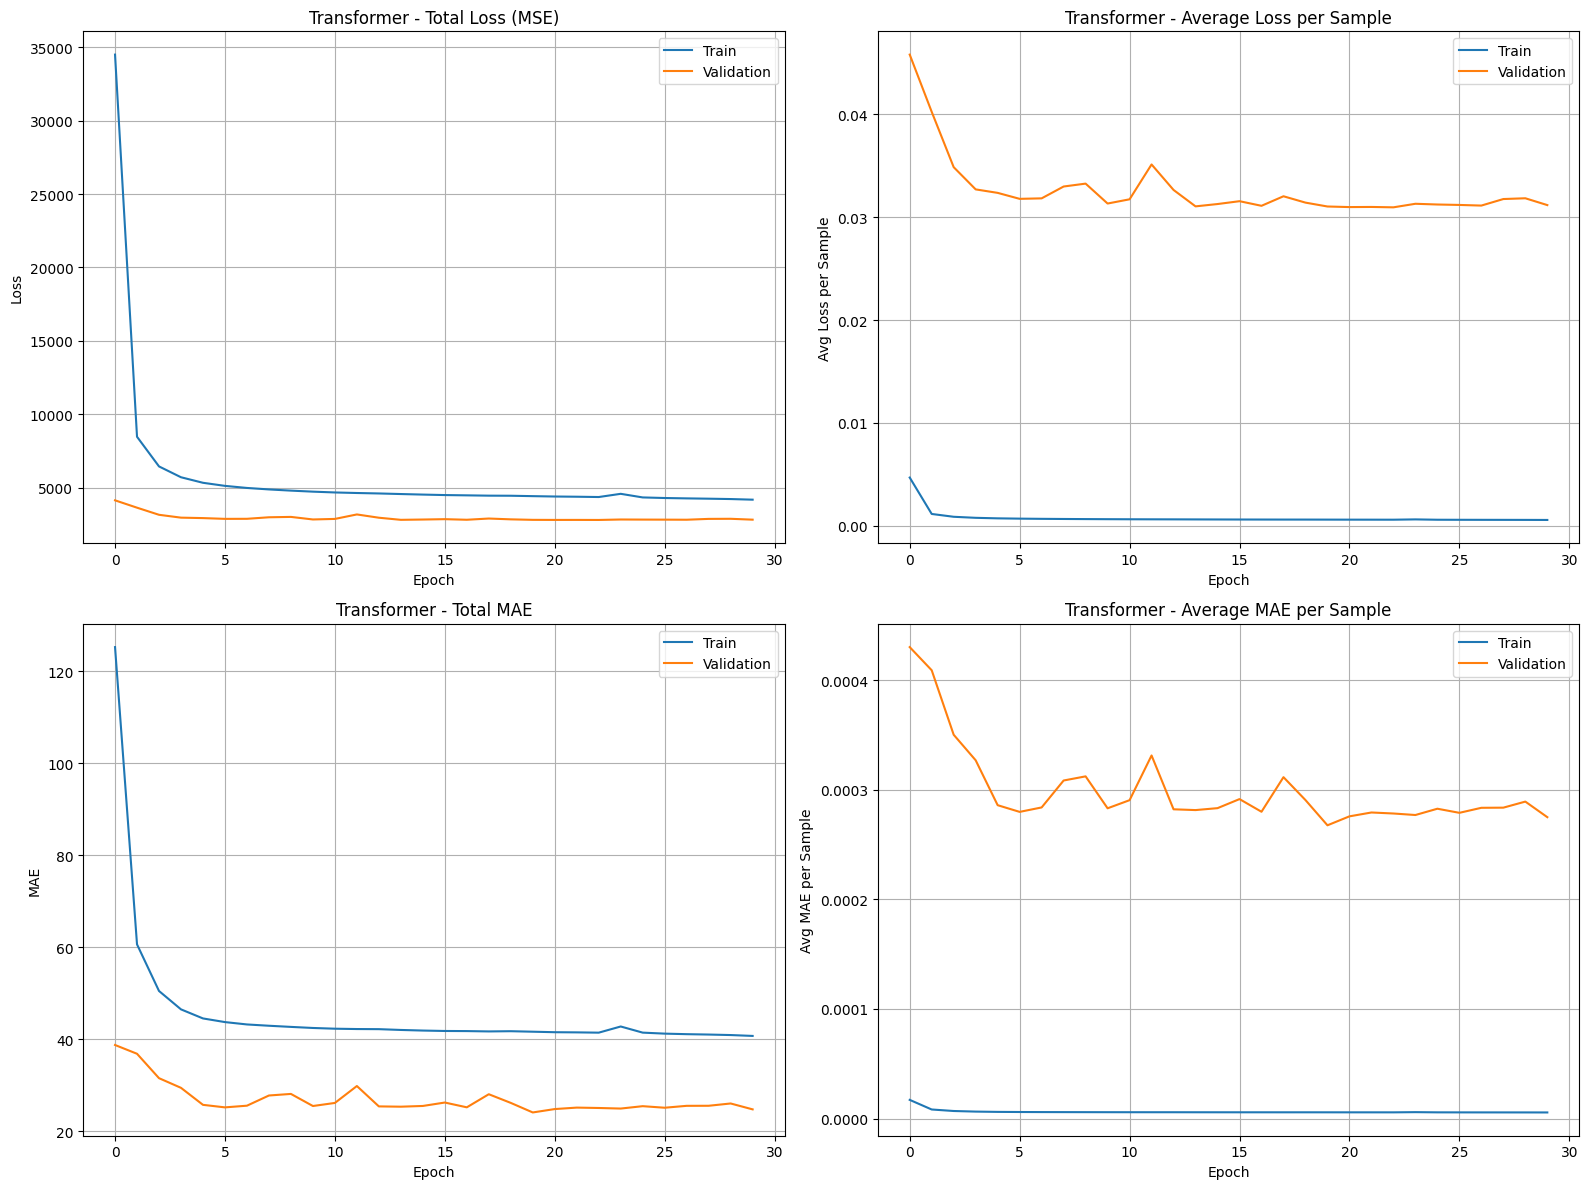


Evaluating Transformer model on test set...

Transformer - Test Evaluation Metrics:
  Overall:  MSE: 2710.51, RMSE: 52.06, MAE: 24.93, R²: 0.9719, WAPE: 10.78%
  Daytime:  MSE: 5430.63, RMSE: 73.69, MAE: 47.30, R²: 0.9366, WAPE: 10.20%
  Nighttime: MSE: 7.48, RMSE: 2.73, MAE: 2.70, R²: -1.9852, WAPE: 872.89%
  Inference Speed: 5913248.78 samples/sec, 0.0002 ms/sample
  Total time: 0.0152 sec for 90112 samples
Model saved to checkpoints/Transformer_best_20250430_193548.pt with metadata.
Best model saved to checkpoints/Transformer_best_20250430_193548.pt
Saved model checkpoint logged to wandb: checkpoints/Transformer_best_20250430_193548.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,████████████████████████████▁▁
train/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


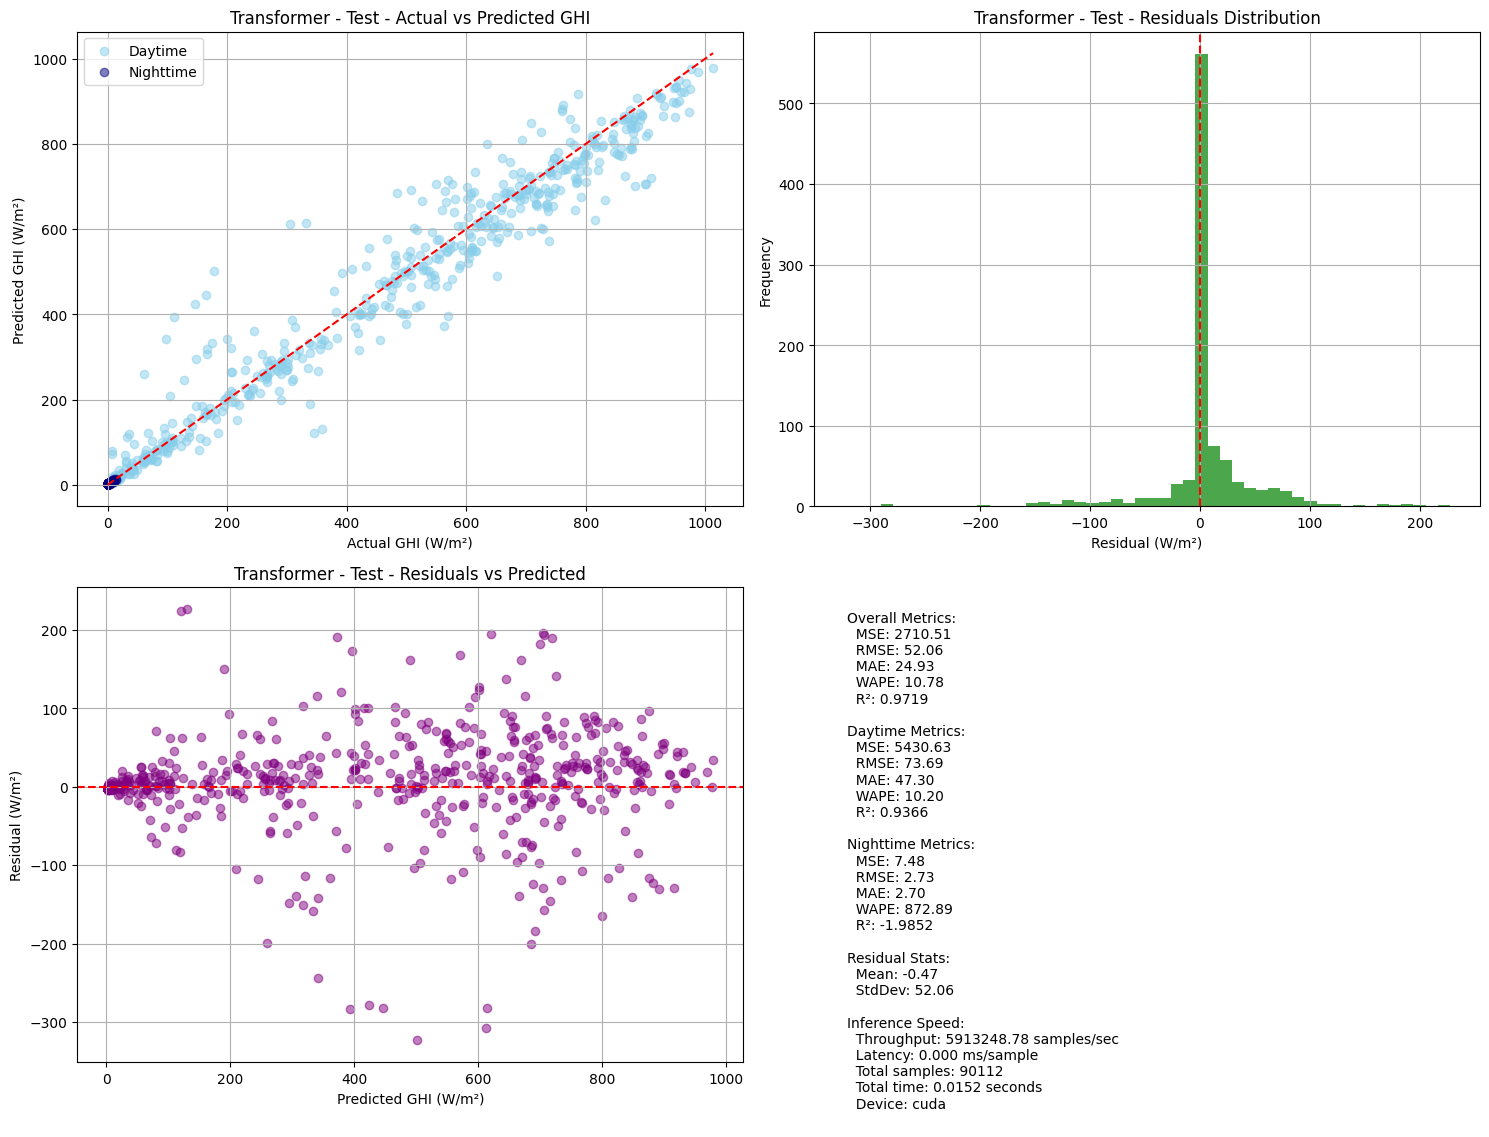

In [10]:
model_name = "Transformer"

# Train the Transformer model
transformer_history, transformer_val_metrics, transformer_test_metrics = run_experiment_pipeline(
    transformer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

### 3.3 Informer Model

The Informer model is a recent advancement in time series forecasting that addresses the limitations of standard Transformer models for long sequence prediction. Key innovations include:

- **ProbSparse Self-attention**: Reduces complexity from O(L²) to O(L log L) where L is sequence length.
- **Self-attention Distilling**: Progressive downsampling of hidden states along the encoder.
- **Generative Decoder**: Enables long sequence prediction with minimal compute.

For solar radiation forecasting, Informer can efficiently capture daily, weekly, and seasonal patterns while focusing computational resources on the most informative timestamps.

In [11]:
from models.informer import InformerModel

# Create Informer model
informer_model = InformerModel(
    input_dim=temporal_dim,           # Dimension of input features
    static_dim=static_dim,            # Dimension of static features
    d_model=128,                      # Model dimension
    n_heads=8,                        # Number of attention heads
    e_layers=3,                       # Number of encoder layers
    d_ff=256,                         # Dimension of feedforward network
    dropout=0.1,                      # Dropout rate
    activation='gelu'                 # Activation function
).to(device)

# Print the model
print_model_info(informer_model, temporal_features.shape, static_features.shape)

Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Model: InformerModel
Total parameters: 412,929
Trainable parameters: 412,929
Non-trainable parameters: 0

Model structure:
InformerModel(
  (enc_embedding): Linear(in_features=19, out_features=128, bias=True)
  (pos_encoder): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=

Training Informer model...
track_experiment: USE_WANDB=True, wandb.run=None, keep_run_open=True
Error generating model summary: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: []
Creating new wandb run for Informer


Training config: {'PATIENCE': 10, 'LR': 0.0001, 'DEBUG_MODE': False, 'N_EPOCHS': 30, 'BATCH_SIZE': 8192, 'NUM_WORKERS': 16, 'USE_WANDB': True, 'WANDB_USERNAME': 'tin-hoang', 'WANDB_PROJECT': 'EEEM073-Solar-Radiation', 'LOOKBACK': 24, 'TIME_FEATURES': ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'dow_sin', 'dow_cos'], 'SELECTED_FEATURES': ['air_temperature', 'wind_speed', 'relative_humidity', 'cloud_type', 'solar_zenith_angle', 'clearsky_ghi', 'total_precipitable_water', 'surface_albedo', 'nighttime_mask', 'cld_opd_dcomp', 'aod'], 'STATIC_FEATURES': ['latitude', 'longitude', 'elevation'], 'TARGET_VARIABLE': 'ghi', 'TRAIN_PREPROCESSED_DATA_PATH': 'data/processed/train_normalized_20250430_145157.h5', 'VAL_PREPROCESSED_DATA_PATH': 'data/processed/val_normalized_20250430_145205.h5', 'TEST_PREPROCESSED_DATA_PATH': 'data/processed/test_normalized_20250430_145205.h5', 'SCALER_PATH': 'data/processed/scalers_20250430_145206.pkl', 'TEMPORAL_FEATURES_SHAPE': [8192, 24, 


Validation Informer (Epoch 1) Evaluation Metrics:
  Overall:  MSE: 3317.01, RMSE: 57.59, MAE: 29.16, R²: 0.9657, WAPE: 12.49%
  Daytime:  MSE: 6629.14, RMSE: 81.42, MAE: 54.74, R²: 0.9211, WAPE: 11.70%
  Nighttime: MSE: 24.37, RMSE: 4.94, MAE: 3.72, R²: -8.4458, WAPE: 1178.13%
  Inference Speed: 9115527.63 samples/sec, 0.0001 ms/sample
  Total time: 0.0099 sec for 90112 samples
Epoch 1/30 | Train Loss: 9705.2324, Train MAE: 60.8081 | Val Loss: 3317.0093, Val MAE: 29.1556 | LR: 0.000100



Validation Informer (Epoch 2) Evaluation Metrics:
  Overall:  MSE: 3057.61, RMSE: 55.30, MAE: 26.87, R²: 0.9683, WAPE: 11.51%
  Daytime:  MSE: 6123.38, RMSE: 78.25, MAE: 51.53, R²: 0.9271, WAPE: 11.01%
  Nighttime: MSE: 9.88, RMSE: 3.14, MAE: 2.37, R²: -2.8306, WAPE: 749.07%
  Inference Speed: 9649394.22 samples/sec, 0.0001 ms/sample
  Total time: 0.0093 sec for 90112 samples
Epoch 2/30 | Train Loss: 4740.5415, Train MAE: 38.2234 | Val Loss: 3057.6072, Val MAE: 26.8735 | LR: 0.000100



Validation Informer (Epoch 3) Evaluation Metrics:
  Overall:  MSE: 2964.82, RMSE: 54.45, MAE: 26.10, R²: 0.9693, WAPE: 11.18%
  Daytime:  MSE: 5942.70, RMSE: 77.09, MAE: 50.90, R²: 0.9293, WAPE: 10.87%
  Nighttime: MSE: 4.46, RMSE: 2.11, MAE: 1.44, R²: -0.7294, WAPE: 456.48%
  Inference Speed: 7540141.28 samples/sec, 0.0001 ms/sample
  Total time: 0.0120 sec for 90112 samples
Epoch 3/30 | Train Loss: 4292.1729, Train MAE: 34.8773 | Val Loss: 2964.8191, Val MAE: 26.0958 | LR: 0.000100



Validation Informer (Epoch 4) Evaluation Metrics:
  Overall:  MSE: 2871.94, RMSE: 53.59, MAE: 25.16, R²: 0.9703, WAPE: 10.78%
  Daytime:  MSE: 5752.30, RMSE: 75.84, MAE: 48.35, R²: 0.9315, WAPE: 10.33%
  Nighttime: MSE: 8.54, RMSE: 2.92, MAE: 2.11, R²: -2.3110, WAPE: 667.79%
  Inference Speed: 5319294.09 samples/sec, 0.0002 ms/sample
  Total time: 0.0169 sec for 90112 samples
Epoch 4/30 | Train Loss: 4063.1562, Train MAE: 33.1590 | Val Loss: 2871.9434, Val MAE: 25.1633 | LR: 0.000100



Validation Informer (Epoch 5) Evaluation Metrics:
  Overall:  MSE: 2877.67, RMSE: 53.64, MAE: 25.79, R²: 0.9702, WAPE: 11.05%
  Daytime:  MSE: 5767.57, RMSE: 75.94, MAE: 50.17, R²: 0.9314, WAPE: 10.72%
  Nighttime: MSE: 4.78, RMSE: 2.19, MAE: 1.56, R²: -0.8524, WAPE: 493.85%
  Inference Speed: 7191512.33 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 5/30 | Train Loss: 3927.4558, Train MAE: 32.3410 | Val Loss: 2877.6697, Val MAE: 25.7938 | LR: 0.000100



Validation Informer (Epoch 6) Evaluation Metrics:
  Overall:  MSE: 2849.48, RMSE: 53.38, MAE: 24.12, R²: 0.9705, WAPE: 10.33%
  Daytime:  MSE: 5713.31, RMSE: 75.59, MAE: 47.38, R²: 0.9320, WAPE: 10.12%
  Nighttime: MSE: 2.50, RMSE: 1.58, MAE: 1.00, R²: 0.0294, WAPE: 316.35%
  Inference Speed: 6594153.95 samples/sec, 0.0002 ms/sample
  Total time: 0.0137 sec for 90112 samples
Epoch 6/30 | Train Loss: 3831.1841, Train MAE: 31.9849 | Val Loss: 2849.4795, Val MAE: 24.1220 | LR: 0.000100



Validation Informer (Epoch 7) Evaluation Metrics:
  Overall:  MSE: 2825.97, RMSE: 53.16, MAE: 23.87, R²: 0.9707, WAPE: 10.22%
  Daytime:  MSE: 5666.59, RMSE: 75.28, MAE: 46.77, R²: 0.9326, WAPE: 9.99%
  Nighttime: MSE: 2.07, RMSE: 1.44, MAE: 1.10, R²: 0.1973, WAPE: 347.66%
  Inference Speed: 9580662.16 samples/sec, 0.0001 ms/sample
  Total time: 0.0094 sec for 90112 samples
Epoch 7/30 | Train Loss: 3765.5061, Train MAE: 31.8689 | Val Loss: 2825.9700, Val MAE: 23.8691 | LR: 0.000100



Validation Informer (Epoch 8) Evaluation Metrics:
  Overall:  MSE: 2815.72, RMSE: 53.06, MAE: 24.85, R²: 0.9708, WAPE: 10.65%
  Daytime:  MSE: 5644.49, RMSE: 75.13, MAE: 48.56, R²: 0.9328, WAPE: 10.38%
  Nighttime: MSE: 3.60, RMSE: 1.90, MAE: 1.29, R²: -0.3970, WAPE: 407.98%
  Inference Speed: 8756101.52 samples/sec, 0.0001 ms/sample
  Total time: 0.0103 sec for 90112 samples
Epoch 8/30 | Train Loss: 3711.3718, Train MAE: 31.8960 | Val Loss: 2815.7229, Val MAE: 24.8548 | LR: 0.000100



Validation Informer (Epoch 9) Evaluation Metrics:
  Overall:  MSE: 2816.36, RMSE: 53.07, MAE: 24.50, R²: 0.9708, WAPE: 10.49%
  Daytime:  MSE: 5646.11, RMSE: 75.14, MAE: 47.96, R²: 0.9328, WAPE: 10.25%
  Nighttime: MSE: 3.26, RMSE: 1.81, MAE: 1.17, R²: -0.2639, WAPE: 371.17%
  Inference Speed: 6511225.77 samples/sec, 0.0002 ms/sample
  Total time: 0.0138 sec for 90112 samples
Epoch 9/30 | Train Loss: 3661.0183, Train MAE: 31.7203 | Val Loss: 2816.3596, Val MAE: 24.4965 | LR: 0.000100



Validation Informer (Epoch 10) Evaluation Metrics:
  Overall:  MSE: 2821.00, RMSE: 53.11, MAE: 24.87, R²: 0.9708, WAPE: 10.65%
  Daytime:  MSE: 5656.02, RMSE: 75.21, MAE: 48.96, R²: 0.9327, WAPE: 10.46%
  Nighttime: MSE: 2.67, RMSE: 1.63, MAE: 0.92, R²: -0.0335, WAPE: 290.28%
  Inference Speed: 8713507.98 samples/sec, 0.0001 ms/sample
  Total time: 0.0103 sec for 90112 samples
Epoch 10/30 | Train Loss: 3618.4468, Train MAE: 31.6550 | Val Loss: 2820.9976, Val MAE: 24.8654 | LR: 0.000100



Validation Informer (Epoch 11) Evaluation Metrics:
  Overall:  MSE: 2787.18, RMSE: 52.79, MAE: 24.49, R²: 0.9711, WAPE: 10.49%
  Daytime:  MSE: 5587.06, RMSE: 74.75, MAE: 47.61, R²: 0.9335, WAPE: 10.17%
  Nighttime: MSE: 3.79, RMSE: 1.95, MAE: 1.50, R²: -0.4685, WAPE: 476.12%
  Inference Speed: 5638794.56 samples/sec, 0.0002 ms/sample
  Total time: 0.0160 sec for 90112 samples
Epoch 11/30 | Train Loss: 3588.0164, Train MAE: 31.7140 | Val Loss: 2787.1831, Val MAE: 24.4878 | LR: 0.000100



Validation Informer (Epoch 12) Evaluation Metrics:
  Overall:  MSE: 2829.23, RMSE: 53.19, MAE: 24.70, R²: 0.9707, WAPE: 10.58%
  Daytime:  MSE: 5673.19, RMSE: 75.32, MAE: 48.63, R²: 0.9325, WAPE: 10.39%
  Nighttime: MSE: 2.02, RMSE: 1.42, MAE: 0.92, R²: 0.2180, WAPE: 290.99%
  Inference Speed: 6783150.07 samples/sec, 0.0001 ms/sample
  Total time: 0.0133 sec for 90112 samples
Epoch 12/30 | Train Loss: 3557.4863, Train MAE: 31.7045 | Val Loss: 2829.2346, Val MAE: 24.7020 | LR: 0.000100



Validation Informer (Epoch 13) Evaluation Metrics:
  Overall:  MSE: 2781.95, RMSE: 52.74, MAE: 24.54, R²: 0.9712, WAPE: 10.51%
  Daytime:  MSE: 5575.83, RMSE: 74.67, MAE: 47.23, R²: 0.9336, WAPE: 10.09%
  Nighttime: MSE: 4.51, RMSE: 2.12, MAE: 1.99, R²: -0.7473, WAPE: 630.37%
  Inference Speed: 7476452.87 samples/sec, 0.0001 ms/sample
  Total time: 0.0121 sec for 90112 samples
Epoch 13/30 | Train Loss: 3520.4385, Train MAE: 31.5289 | Val Loss: 2781.9463, Val MAE: 24.5448 | LR: 0.000100



Validation Informer (Epoch 14) Evaluation Metrics:
  Overall:  MSE: 2795.05, RMSE: 52.87, MAE: 23.92, R²: 0.9711, WAPE: 10.25%
  Daytime:  MSE: 5606.00, RMSE: 74.87, MAE: 47.43, R²: 0.9333, WAPE: 10.13%
  Nighttime: MSE: 0.64, RMSE: 0.80, MAE: 0.56, R²: 0.7519, WAPE: 176.23%
  Inference Speed: 9474271.73 samples/sec, 0.0001 ms/sample
  Total time: 0.0095 sec for 90112 samples
Epoch 14/30 | Train Loss: 3482.7163, Train MAE: 31.3776 | Val Loss: 2795.0452, Val MAE: 23.9244 | LR: 0.000100



Validation Informer (Epoch 15) Evaluation Metrics:
  Overall:  MSE: 2764.28, RMSE: 52.58, MAE: 23.63, R²: 0.9714, WAPE: 10.12%
  Daytime:  MSE: 5544.15, RMSE: 74.46, MAE: 46.74, R²: 0.9340, WAPE: 9.99%
  Nighttime: MSE: 0.77, RMSE: 0.88, MAE: 0.66, R²: 0.7020, WAPE: 207.56%
  Inference Speed: 7396565.92 samples/sec, 0.0001 ms/sample
  Total time: 0.0122 sec for 90112 samples
Epoch 15/30 | Train Loss: 3443.2502, Train MAE: 31.2578 | Val Loss: 2764.2776, Val MAE: 23.6298 | LR: 0.000100



Validation Informer (Epoch 16) Evaluation Metrics:
  Overall:  MSE: 2771.26, RMSE: 52.64, MAE: 23.37, R²: 0.9713, WAPE: 10.01%
  Daytime:  MSE: 5558.45, RMSE: 74.56, MAE: 46.43, R²: 0.9339, WAPE: 9.92%
  Nighttime: MSE: 0.47, RMSE: 0.69, MAE: 0.45, R²: 0.8171, WAPE: 143.22%
  Inference Speed: 8373368.83 samples/sec, 0.0001 ms/sample
  Total time: 0.0108 sec for 90112 samples
Epoch 16/30 | Train Loss: 3414.9307, Train MAE: 31.2505 | Val Loss: 2771.2593, Val MAE: 23.3743 | LR: 0.000100



Validation Informer (Epoch 17) Evaluation Metrics:
  Overall:  MSE: 2793.74, RMSE: 52.86, MAE: 24.55, R²: 0.9711, WAPE: 10.52%
  Daytime:  MSE: 5603.35, RMSE: 74.86, MAE: 48.71, R²: 0.9333, WAPE: 10.41%
  Nighttime: MSE: 0.67, RMSE: 0.82, MAE: 0.54, R²: 0.7386, WAPE: 171.62%
  Inference Speed: 9352364.88 samples/sec, 0.0001 ms/sample
  Total time: 0.0096 sec for 90112 samples
Epoch 17/30 | Train Loss: 3389.2676, Train MAE: 31.2718 | Val Loss: 2793.7439, Val MAE: 24.5543 | LR: 0.000100



Validation Informer (Epoch 18) Evaluation Metrics:
  Overall:  MSE: 2772.80, RMSE: 52.66, MAE: 24.03, R²: 0.9713, WAPE: 10.29%
  Daytime:  MSE: 5561.08, RMSE: 74.57, MAE: 47.42, R²: 0.9338, WAPE: 10.13%
  Nighttime: MSE: 0.93, RMSE: 0.96, MAE: 0.78, R²: 0.6407, WAPE: 247.46%
  Inference Speed: 6361950.58 samples/sec, 0.0002 ms/sample
  Total time: 0.0142 sec for 90112 samples
Epoch 18/30 | Train Loss: 3372.7195, Train MAE: 31.3125 | Val Loss: 2772.7959, Val MAE: 24.0336 | LR: 0.000100



Validation Informer (Epoch 19) Evaluation Metrics:
  Overall:  MSE: 2799.60, RMSE: 52.91, MAE: 24.57, R²: 0.9710, WAPE: 10.52%
  Daytime:  MSE: 5615.19, RMSE: 74.93, MAE: 48.85, R²: 0.9332, WAPE: 10.44%
  Nighttime: MSE: 0.59, RMSE: 0.77, MAE: 0.43, R²: 0.7729, WAPE: 136.07%
  Inference Speed: 8065666.28 samples/sec, 0.0001 ms/sample
  Total time: 0.0112 sec for 90112 samples
Epoch 19/30 | Train Loss: 3350.5752, Train MAE: 31.2643 | Val Loss: 2799.5994, Val MAE: 24.5691 | LR: 0.000100



Validation Informer (Epoch 20) Evaluation Metrics:
  Overall:  MSE: 2781.39, RMSE: 52.74, MAE: 24.28, R²: 0.9712, WAPE: 10.40%
  Daytime:  MSE: 5578.41, RMSE: 74.69, MAE: 48.01, R²: 0.9336, WAPE: 10.26%
  Nighttime: MSE: 0.83, RMSE: 0.91, MAE: 0.69, R²: 0.6797, WAPE: 219.22%
  Inference Speed: 8249817.13 samples/sec, 0.0001 ms/sample
  Total time: 0.0109 sec for 90112 samples
Epoch 20/30 | Train Loss: 3326.8704, Train MAE: 31.0922 | Val Loss: 2781.3884, Val MAE: 24.2826 | LR: 0.000100



Validation Informer (Epoch 21) Evaluation Metrics:
  Overall:  MSE: 2783.84, RMSE: 52.76, MAE: 24.07, R²: 0.9712, WAPE: 10.31%
  Daytime:  MSE: 5583.62, RMSE: 74.72, MAE: 47.83, R²: 0.9336, WAPE: 10.22%
  Nighttime: MSE: 0.55, RMSE: 0.74, MAE: 0.46, R²: 0.7886, WAPE: 145.09%
  Inference Speed: 9377890.53 samples/sec, 0.0001 ms/sample
  Total time: 0.0096 sec for 90112 samples
Epoch 21/30 | Train Loss: 3303.9849, Train MAE: 31.0046 | Val Loss: 2783.8428, Val MAE: 24.0743 | LR: 0.000050



Validation Informer (Epoch 22) Evaluation Metrics:
  Overall:  MSE: 2756.83, RMSE: 52.51, MAE: 23.82, R²: 0.9715, WAPE: 10.20%
  Daytime:  MSE: 5529.10, RMSE: 74.36, MAE: 47.04, R²: 0.9342, WAPE: 10.05%
  Nighttime: MSE: 0.88, RMSE: 0.94, MAE: 0.74, R²: 0.6596, WAPE: 233.40%
  Inference Speed: 8814298.56 samples/sec, 0.0001 ms/sample
  Total time: 0.0102 sec for 90112 samples
Epoch 22/30 | Train Loss: 3278.2471, Train MAE: 30.9607 | Val Loss: 2756.8315, Val MAE: 23.8186 | LR: 0.000050



Validation Informer (Epoch 23) Evaluation Metrics:
  Overall:  MSE: 2791.55, RMSE: 52.84, MAE: 24.07, R²: 0.9711, WAPE: 10.31%
  Daytime:  MSE: 5599.23, RMSE: 74.83, MAE: 47.94, R²: 0.9334, WAPE: 10.24%
  Nighttime: MSE: 0.39, RMSE: 0.63, MAE: 0.33, R²: 0.8482, WAPE: 105.66%
  Inference Speed: 7655758.11 samples/sec, 0.0001 ms/sample
  Total time: 0.0118 sec for 90112 samples
Epoch 23/30 | Train Loss: 3273.9351, Train MAE: 31.0034 | Val Loss: 2791.5479, Val MAE: 24.0672 | LR: 0.000050



Validation Informer (Epoch 24) Evaluation Metrics:
  Overall:  MSE: 2781.30, RMSE: 52.74, MAE: 23.27, R²: 0.9712, WAPE: 9.97%
  Daytime:  MSE: 5578.52, RMSE: 74.69, MAE: 46.20, R²: 0.9336, WAPE: 9.87%
  Nighttime: MSE: 0.54, RMSE: 0.74, MAE: 0.47, R²: 0.7900, WAPE: 150.29%
  Inference Speed: 9195589.56 samples/sec, 0.0001 ms/sample
  Total time: 0.0098 sec for 90112 samples
Epoch 24/30 | Train Loss: 3262.4109, Train MAE: 31.0209 | Val Loss: 2781.2993, Val MAE: 23.2708 | LR: 0.000050



Validation Informer (Epoch 25) Evaluation Metrics:
  Overall:  MSE: 2779.82, RMSE: 52.72, MAE: 23.32, R²: 0.9712, WAPE: 9.99%
  Daytime:  MSE: 5575.46, RMSE: 74.67, MAE: 46.19, R²: 0.9337, WAPE: 9.87%
  Nighttime: MSE: 0.65, RMSE: 0.80, MAE: 0.58, R²: 0.7497, WAPE: 183.51%
  Inference Speed: 7175810.64 samples/sec, 0.0001 ms/sample
  Total time: 0.0126 sec for 90112 samples
Epoch 25/30 | Train Loss: 3253.6057, Train MAE: 31.0359 | Val Loss: 2779.8245, Val MAE: 23.3158 | LR: 0.000050



Validation Informer (Epoch 26) Evaluation Metrics:
  Overall:  MSE: 2788.36, RMSE: 52.80, MAE: 24.06, R²: 0.9711, WAPE: 10.31%
  Daytime:  MSE: 5592.42, RMSE: 74.78, MAE: 47.51, R²: 0.9335, WAPE: 10.15%
  Nighttime: MSE: 0.81, RMSE: 0.90, MAE: 0.75, R²: 0.6856, WAPE: 238.22%
  Inference Speed: 6280339.68 samples/sec, 0.0002 ms/sample
  Total time: 0.0143 sec for 90112 samples
Epoch 26/30 | Train Loss: 3243.4199, Train MAE: 31.0334 | Val Loss: 2788.3623, Val MAE: 24.0635 | LR: 0.000050



Validation Informer (Epoch 27) Evaluation Metrics:
  Overall:  MSE: 2786.90, RMSE: 52.79, MAE: 24.10, R²: 0.9711, WAPE: 10.32%
  Daytime:  MSE: 5589.31, RMSE: 74.76, MAE: 47.46, R²: 0.9335, WAPE: 10.14%
  Nighttime: MSE: 0.99, RMSE: 0.99, MAE: 0.87, R²: 0.6177, WAPE: 276.63%
  Inference Speed: 8555518.08 samples/sec, 0.0001 ms/sample
  Total time: 0.0105 sec for 90112 samples
Epoch 27/30 | Train Loss: 3237.4961, Train MAE: 31.0572 | Val Loss: 2786.9023, Val MAE: 24.0967 | LR: 0.000050



Validation Informer (Epoch 28) Evaluation Metrics:
  Overall:  MSE: 2803.50, RMSE: 52.95, MAE: 23.80, R²: 0.9710, WAPE: 10.19%
  Daytime:  MSE: 5622.23, RMSE: 74.98, MAE: 46.66, R²: 0.9331, WAPE: 9.97%
  Nighttime: MSE: 1.36, RMSE: 1.16, MAE: 1.07, R²: 0.4741, WAPE: 339.30%
  Inference Speed: 7206183.57 samples/sec, 0.0001 ms/sample
  Total time: 0.0125 sec for 90112 samples
Epoch 28/30 | Train Loss: 3228.3125, Train MAE: 31.0470 | Val Loss: 2803.4963, Val MAE: 23.7975 | LR: 0.000025



Validation Informer (Epoch 29) Evaluation Metrics:
  Overall:  MSE: 2779.88, RMSE: 52.72, MAE: 23.77, R²: 0.9712, WAPE: 10.18%
  Daytime:  MSE: 5575.45, RMSE: 74.67, MAE: 46.95, R²: 0.9337, WAPE: 10.03%
  Nighttime: MSE: 0.77, RMSE: 0.88, MAE: 0.73, R²: 0.7028, WAPE: 230.67%
  Inference Speed: 9252769.34 samples/sec, 0.0001 ms/sample
  Total time: 0.0097 sec for 90112 samples
Epoch 29/30 | Train Loss: 3212.6978, Train MAE: 30.9937 | Val Loss: 2779.8823, Val MAE: 23.7705 | LR: 0.000025



Validation Informer (Epoch 30) Evaluation Metrics:
  Overall:  MSE: 2784.99, RMSE: 52.77, MAE: 23.65, R²: 0.9712, WAPE: 10.13%
  Daytime:  MSE: 5585.91, RMSE: 74.74, MAE: 46.92, R²: 0.9335, WAPE: 10.03%
  Nighttime: MSE: 0.55, RMSE: 0.74, MAE: 0.52, R²: 0.7871, WAPE: 165.13%
  Inference Speed: 7168733.23 samples/sec, 0.0001 ms/sample
  Total time: 0.0126 sec for 90112 samples
Epoch 30/30 | Train Loss: 3206.0703, Train MAE: 30.9788 | Val Loss: 2784.9885, Val MAE: 23.6528 | LR: 0.000025
Loading best model from training session. The model object now can be used to make predictions.
Keeping wandb run open as requested (keep_run_open=True)


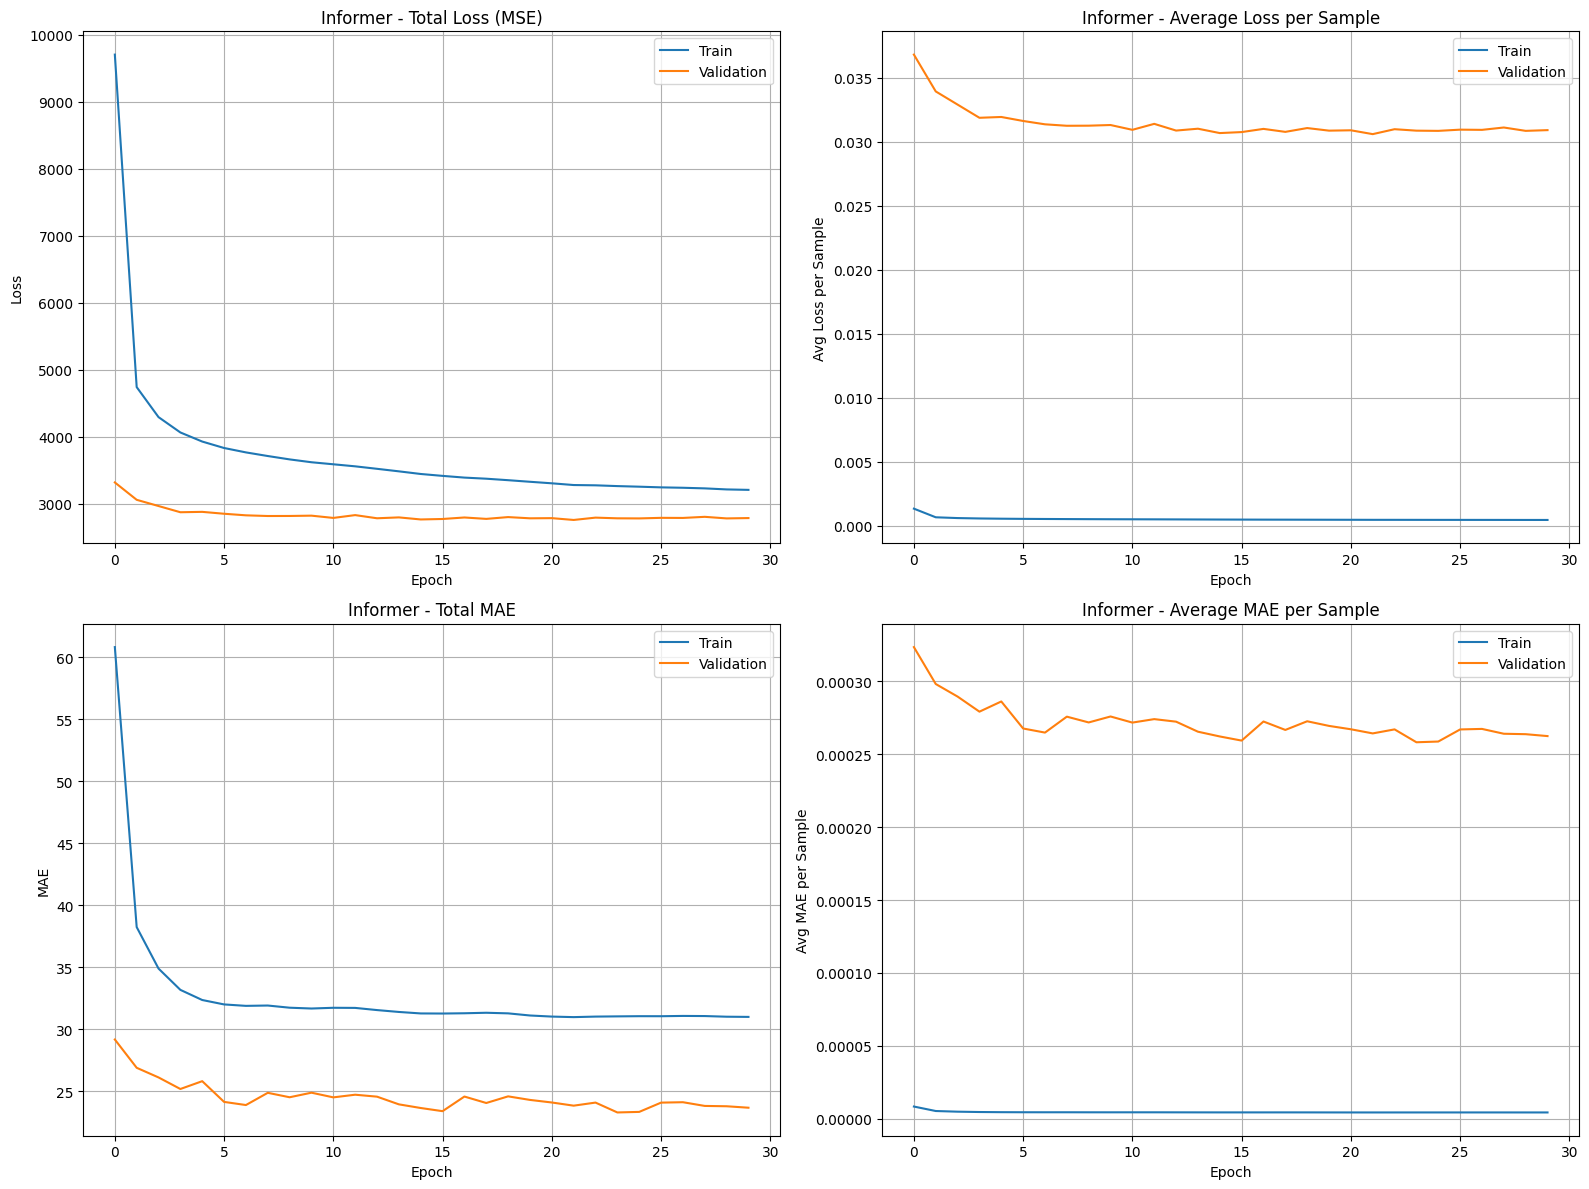


Evaluating Informer model on test set...

Informer - Test Evaluation Metrics:
  Overall:  MSE: 2686.13, RMSE: 51.83, MAE: 23.77, R²: 0.9721, WAPE: 10.27%
  Daytime:  MSE: 5388.71, RMSE: 73.41, MAE: 47.17, R²: 0.9371, WAPE: 10.17%
  Nighttime: MSE: 0.53, RMSE: 0.73, MAE: 0.52, R²: 0.7876, WAPE: 167.05%
  Inference Speed: 7293231.23 samples/sec, 0.0001 ms/sample
  Total time: 0.0124 sec for 90112 samples
Model saved to checkpoints/Informer_best_20250430_214758.pt with metadata.
Best model saved to checkpoints/Informer_best_20250430_214758.pt
Saved model checkpoint logged to wandb: checkpoints/Informer_best_20250430_214758.pt


test/inference_speed_samples_per_sec,▁
test/inference_time_ms_per_sample,▁
test/mae,▁
test/mse,▁
test/r2,▁
test/rmse,▁
test/wape,▁
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train/learning_rate,████████████████████▃▃▃▃▃▃▃▁▁▁
train/loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/mae,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


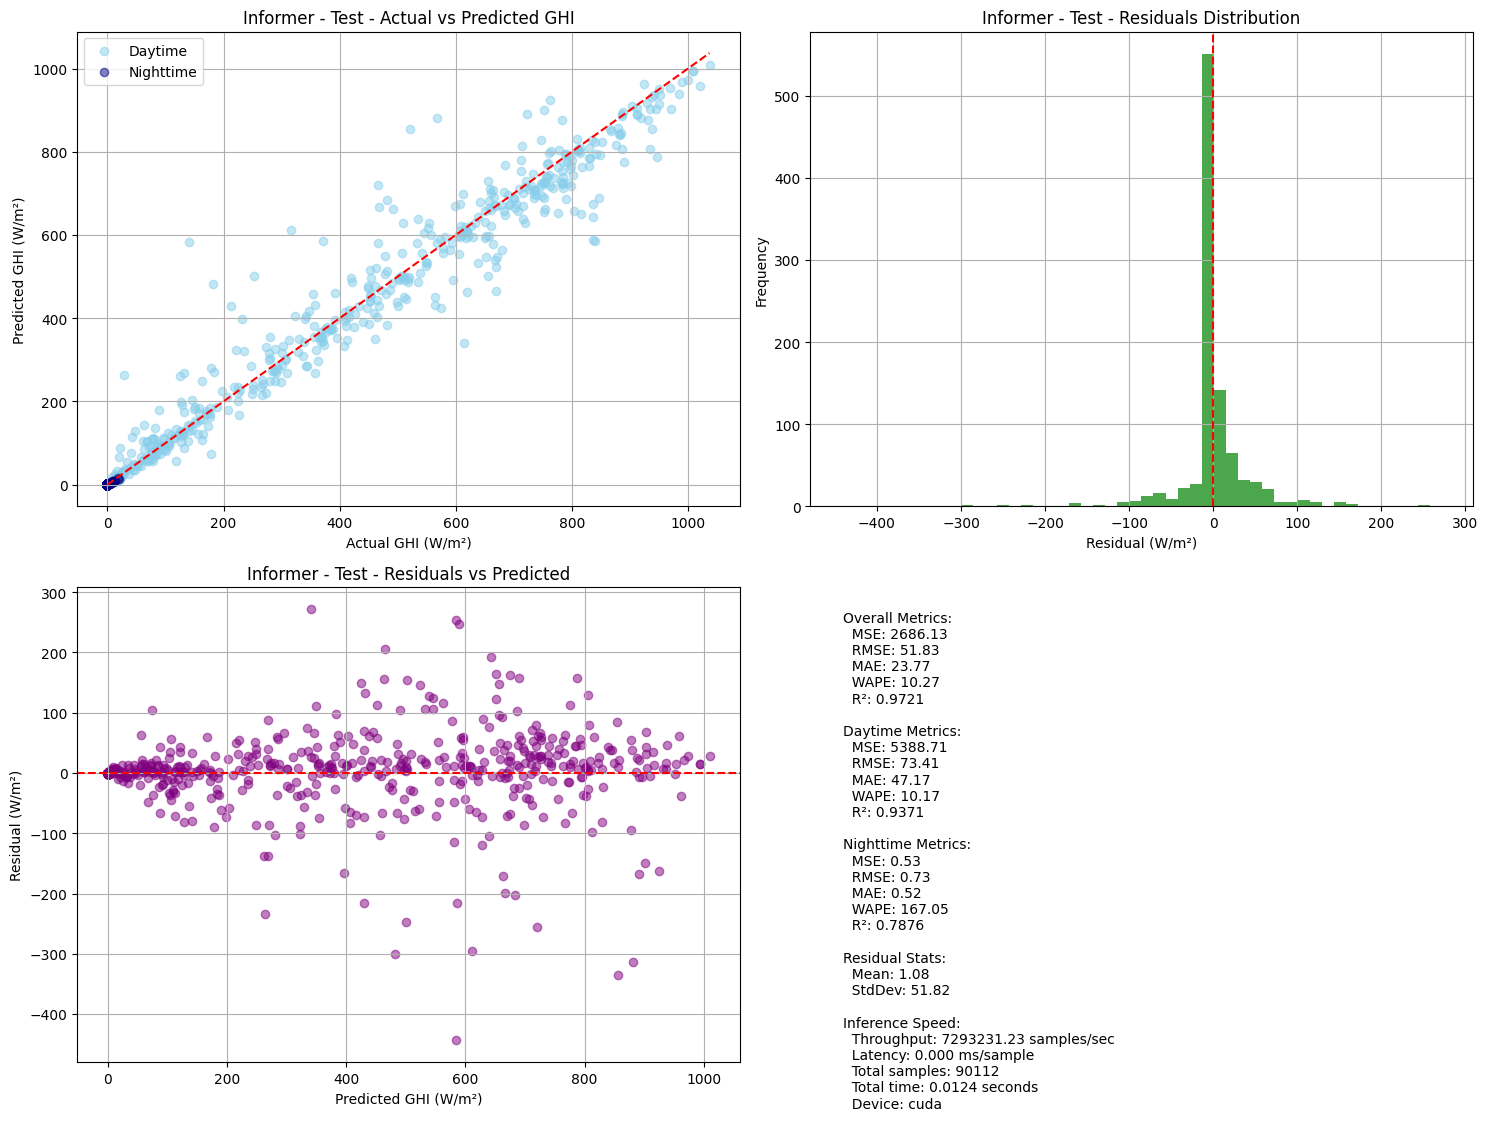

In [12]:
model_name = "Informer"

# Train the Informer model with a lower learning rate
informer_history, informer_val_metrics, informer_test_metrics = run_experiment_pipeline(
    informer_model,
    train_loader,
    val_loader,
    test_loader,
    model_name=model_name,
    epochs=N_EPOCHS,
    patience=PATIENCE,
    lr=LR
)

## 4. Model Comparison

## 4.1 Compare Models' Performance


Test Set Comparison:

Model Comparison - Test Set Set:
                        TCN     Transformer        Informer
MSE             2779.045166     2710.507324     2686.132568
RMSE               52.71665       52.062533       51.827913
MAE               25.046539       24.932087        23.76779
WAPE               10.82567       10.776201       10.272965
R²                 0.971173        0.971884        0.972137
Samples/sec  6108990.319029  5913248.776507  7293231.230303
ms/sample          0.000164        0.000169        0.000137
Input DataFrame for visualization:
                        TCN     Transformer        Informer
MSE             2779.045166     2710.507324     2686.132568
RMSE               52.71665       52.062533       51.827913
MAE               25.046539       24.932087        23.76779
WAPE               10.82567       10.776201       10.272965
R²                 0.971173        0.971884        0.972137
Samples/sec  6108990.319029  5913248.776507  7293231.230303
ms/sample

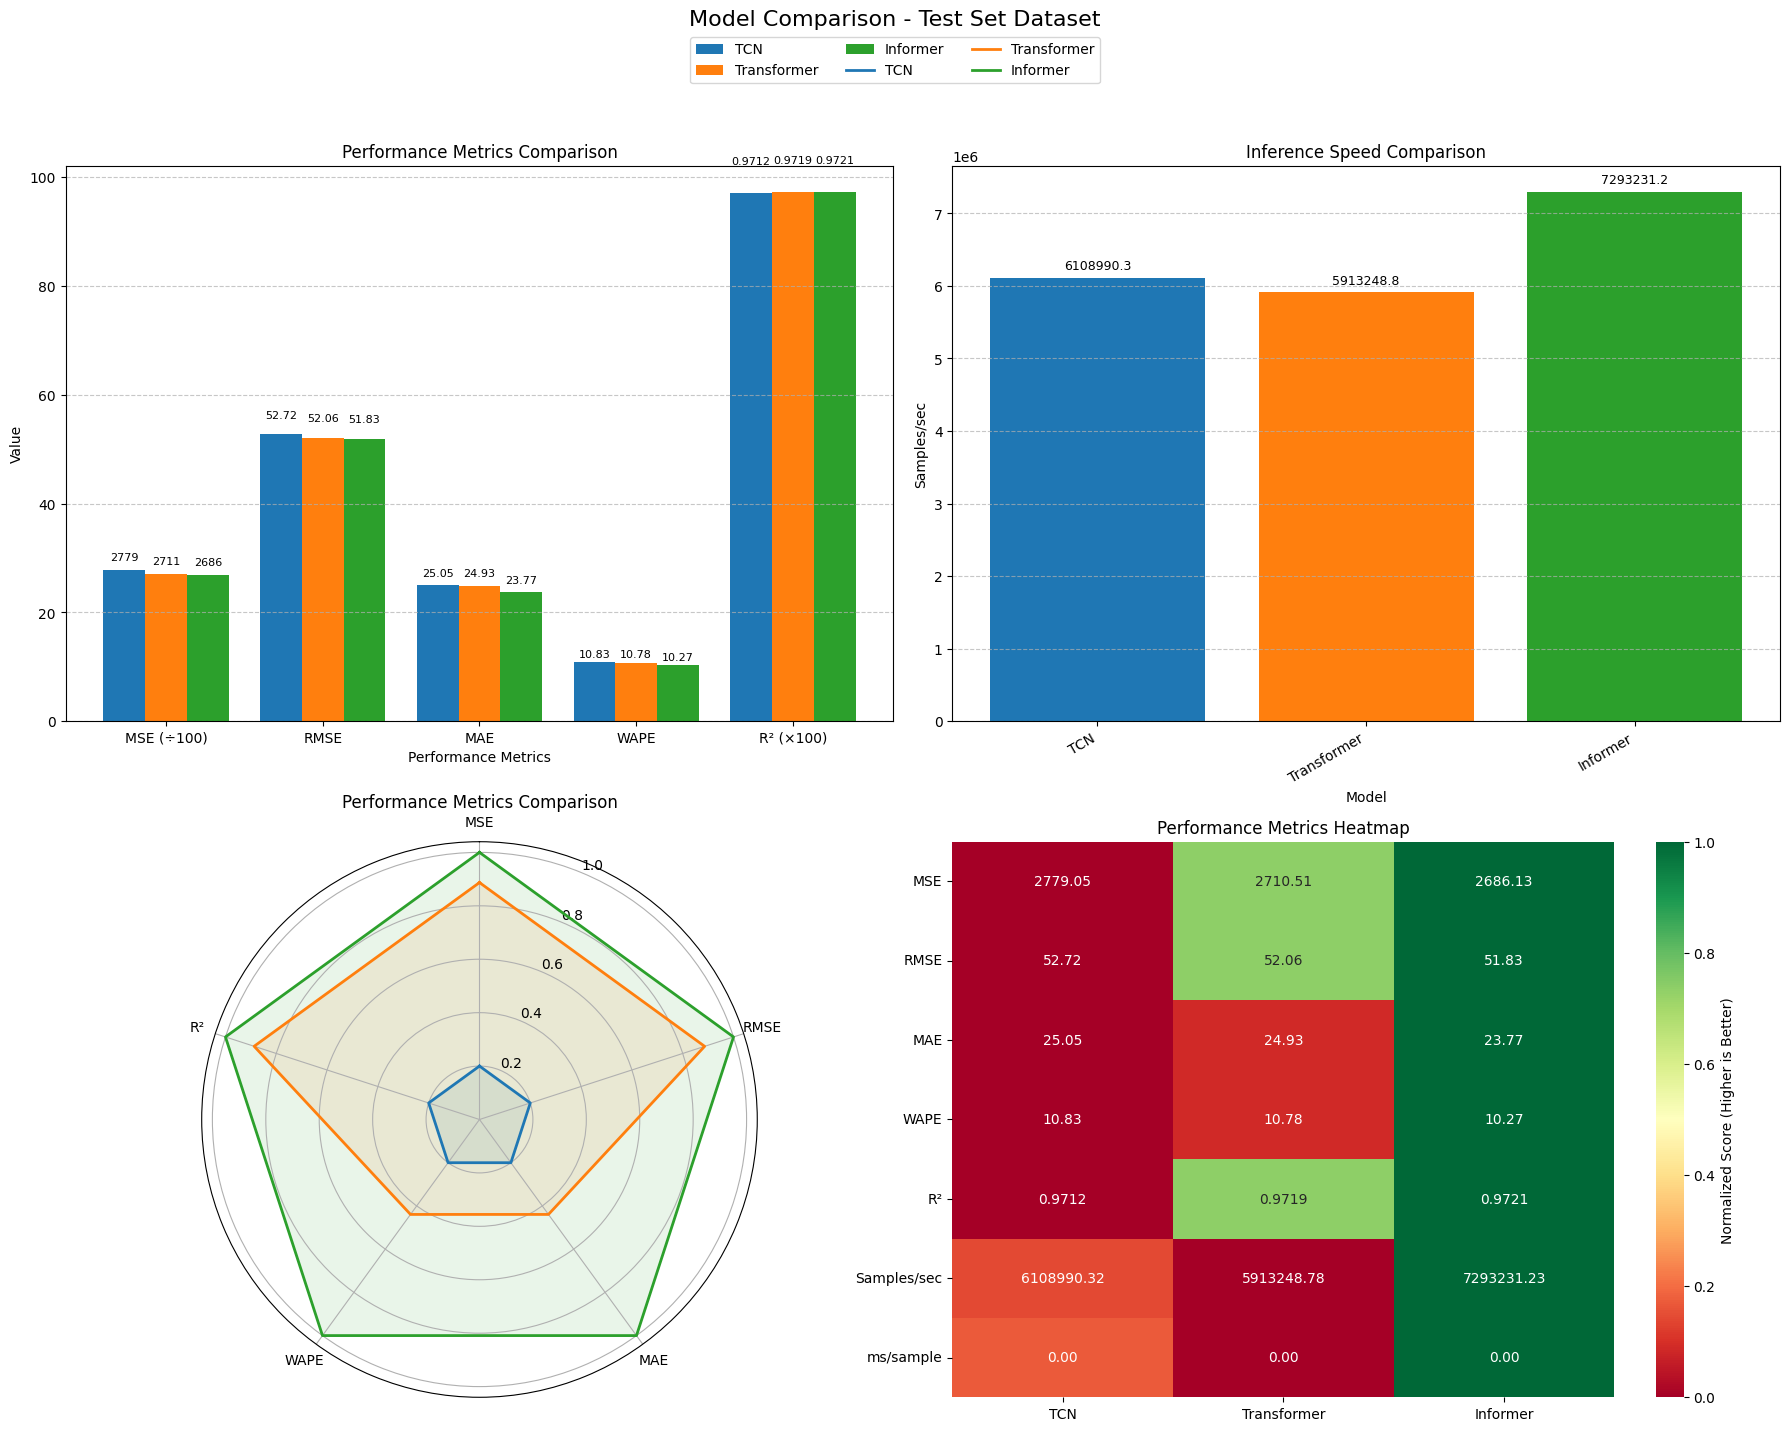

(                        TCN     Transformer        Informer
 MSE             2779.045166     2710.507324     2686.132568
 RMSE               52.71665       52.062533       51.827913
 MAE               25.046539       24.932087        23.76779
 WAPE               10.82567       10.776201       10.272965
 R²                 0.971173        0.971884        0.972137
 Samples/sec  6108990.319029  5913248.776507  7293231.230303
 ms/sample          0.000164        0.000169        0.000137,
 <Figure size 1800x2100 with 5 Axes>)

<Figure size 640x480 with 0 Axes>

In [13]:
from utils.plot_utils import compare_models

# Create a dictionary of model metrics
model_metrics = {
    'TCN': tcn_test_metrics,
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics
}

# Compare model performance on test set
print("\nTest Set Comparison:")
compare_models(model_metrics, dataset_name='Test Set')

## 4.2 Model Comparison on Daytime/Nighttime/Overall

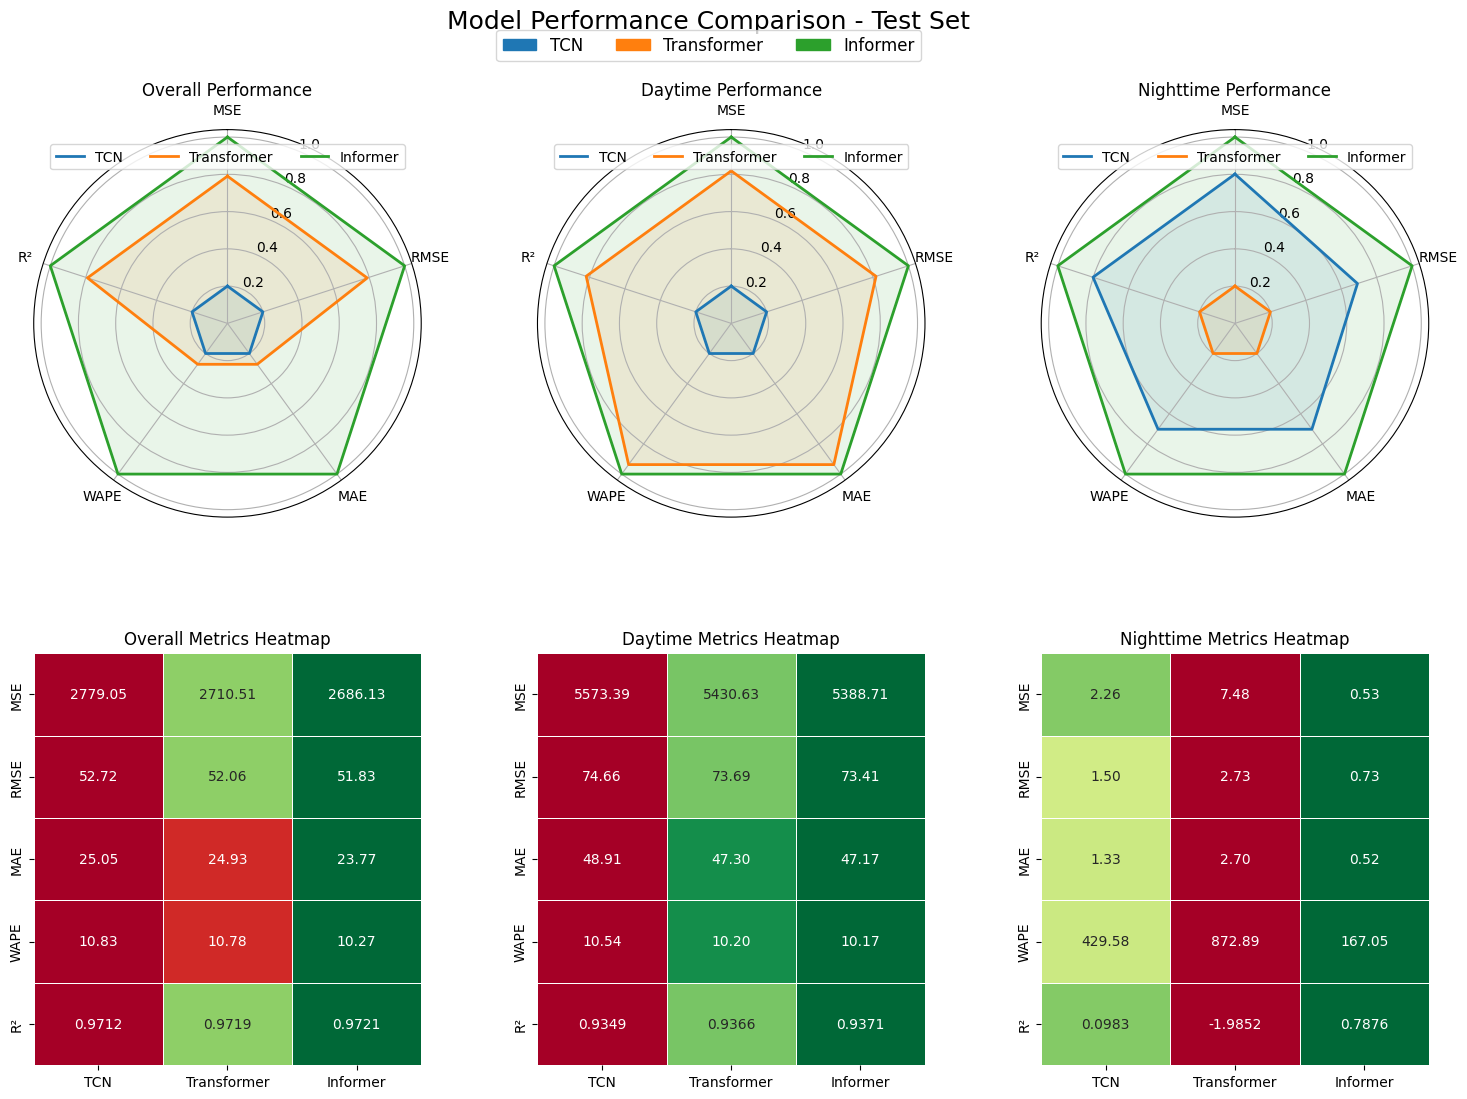

In [14]:
from utils.plot_utils import compare_models_daytime_nighttime

# Create a dictionary of model metrics
model_metrics = {
    'TCN': tcn_test_metrics,
    'Transformer': transformer_test_metrics,
    'Informer': informer_test_metrics
}

# Generate the comparison plot
comparison_fig = compare_models_daytime_nighttime(model_metrics, dataset_name='Test Set')

## 5. Train and Evaluate Models

### 5.2 Time Series Predictions

Visualize predictions over time.

In [15]:
def plot_predictions_over_time(models, model_names, data_loader, target_scaler, num_samples=200, start_idx=0):
    """
    Plot time series predictions for multiple models with nighttime shading if available

    Args:
        models: List of PyTorch models
        model_names: List of model names
        data_loader: Data loader
        target_scaler: Scaler for the target variable
        num_samples: Number of consecutive time steps to plot
        start_idx: Starting index in the dataset
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    import os
    from matplotlib.patches import Patch
    import matplotlib.dates as mdates
    from datetime import datetime

    # Get device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Collect data samples
    all_batches = []
    for batch in data_loader:
        all_batches.append(batch)
        if len(all_batches) * batch['target'].shape[0] > start_idx + num_samples:
            break

    # Combine batches into a single dataset
    all_temporal = []
    all_static = []
    all_targets = []
    all_nighttime = []
    all_time_index_local = []
    has_nighttime = False
    has_time_index_local = False

    for batch in all_batches:
        all_temporal.append(batch['temporal_features'])
        all_static.append(batch['static_features'])
        all_targets.append(batch['target'])
        # Check if nighttime data is available
        if 'nighttime_mask' in batch:
            has_nighttime = True
            all_nighttime.append(batch['nighttime_mask'])
        # Check if time_index_local is available
        if 'time_index_local' in batch:
            has_time_index_local = True
            # Store the time index values as they are
            if isinstance(batch['time_index_local'], list):
                all_time_index_local.extend(batch['time_index_local'])
            else:
                all_time_index_local.append(batch['time_index_local'])

    all_temporal = torch.cat(all_temporal, dim=0)
    all_static = torch.cat(all_static, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    if has_nighttime:
        all_nighttime = torch.cat(all_nighttime, dim=0)

    # Get the subset for visualization
    temporal = all_temporal[start_idx:start_idx+num_samples].to(device)
    static = all_static[start_idx:start_idx+num_samples].to(device)
    targets = all_targets[start_idx:start_idx+num_samples].cpu().numpy()

    if has_nighttime:
        nighttime = all_nighttime[start_idx:start_idx+num_samples].cpu().numpy()
        # Ensure nighttime is a 1D array
        if len(nighttime.shape) > 1:
            nighttime = nighttime.flatten() if nighttime.shape[1] == 1 else nighttime[:,0]

    # Get time index for x-axis if available
    x_values = None
    if has_time_index_local and len(all_time_index_local) >= start_idx + num_samples:
        # Extract the time values for the plotting window
        x_values = all_time_index_local[start_idx:start_idx+num_samples]

        # Try to convert to datetime objects if they are strings
        if isinstance(x_values[0], str):
            try:
                # Try different datetime formats
                date_formats = ['%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%Y-%m-%dT%H:%M:%S', '%Y%m%d%H%M%S']
                for date_format in date_formats:
                    try:
                        x_values = [datetime.strptime(t, date_format) for t in x_values]
                        print(f"Successfully parsed dates with format: {date_format}")
                        break
                    except ValueError:
                        continue

                # If we couldn't parse with any format, notify and use indices
                if isinstance(x_values[0], str):
                    print(f"Could not parse date format: {x_values[0]}, using indices instead")
                    x_values = None

            except (ValueError, TypeError) as e:
                # If conversion fails, fall back to using indices
                print(f"Error converting time_index_local to datetime: {e}, using indices instead")
                x_values = None

    # Generate predictions
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            outputs = model(temporal, static).cpu().numpy()
            predictions.append(outputs)

    # Inverse transform to original scale
    y_true_orig = target_scaler.inverse_transform(targets.reshape(-1, 1)).flatten()
    y_pred_orig_list = [target_scaler.inverse_transform(pred.reshape(-1, 1)).flatten() for pred in predictions]

    # Create visualization
    fig = plt.figure(figsize=(15, 8))
    ax = plt.gca()

    # Define colors and line styles for predictions
    colors = ['blue', 'red', 'green', 'magenta', 'cyan', 'orange']
    line_styles = ['--', ':', '-.', '--', ':', '--']

    # Set x-axis values based on availability of time_index_local
    if x_values:
        # Plot actual values with time index
        actual_line, = plt.plot(x_values, y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions with time index
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(x_values, pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # Format the x-axis to show dates properly
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
        plt.xticks(rotation=0)  # Make labels horizontal
        fig.subplots_adjust(bottom=0.15)  # Adjust bottom margin for horizontal labels

        # If we have nighttime data, shade those regions
        if has_nighttime:
            # Modify nighttime shading to work with datetime x-axis
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                if start < len(x_values) and end <= len(x_values):
                    ax.axvspan(x_values[start], x_values[min(end, len(x_values)-1)],
                              alpha=0.2, color='gray', label='_nolegend_')
    else:
        # Use default integer indices for x-axis
        actual_line, = plt.plot(y_true_orig, 'k-', label='Actual GHI', linewidth=2)

        # Plot predictions and collect handles/labels
        pred_lines = []
        handles = [actual_line]
        labels = ['Actual GHI']

        for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
            color = colors[i % len(colors)]
            style = line_styles[i % len(line_styles)]
            line, = plt.plot(pred, color=color, linestyle=style, label=f'{name} Predicted', alpha=0.7)
            pred_lines.append(line)
            handles.append(line)
            labels.append(f'{name} Predicted')

        # If we have nighttime data, shade those regions
        if has_nighttime:
            nighttime_bool = (nighttime > 0.5)
            night_regions = []
            start = None
            for i, is_night in enumerate(nighttime_bool):
                if is_night and start is None:
                    start = i
                elif not is_night and start is not None:
                    night_regions.append((start, i))
                    start = None
            if start is not None:
                night_regions.append((start, len(nighttime_bool)))

            for start, end in night_regions:
                ax.axvspan(start, end, alpha=0.2, color='gray', label='_nolegend_')

    # Add nighttime legend if applicable
    if has_nighttime and len(night_regions) > 0:
        night_patch = Patch(facecolor='gray', alpha=0.2, label='Nighttime')
        handles.append(night_patch)
        labels.append('Nighttime')

    # Calculate and display error metrics for the visualization window
    for i, (pred, name) in enumerate(zip(y_pred_orig_list, model_names)):
        rmse = np.sqrt(np.mean((y_true_orig - pred) ** 2))
        mae = np.mean(np.abs(y_true_orig - pred))
        plt.annotate(f"{name}: RMSE={rmse:.2f}, MAE={mae:.2f}",
                     xy=(0.02, 0.97 - 0.03*i),
                     xycoords='axes fraction',
                     fontsize=9,
                     bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))

    plt.title('GHI Predictions Over Time')
    plt.xlabel('Time' if x_values else 'Time Step')
    plt.ylabel('GHI (W/m²)')

    # Set the legend with the correct handles and labels
    plt.legend(handles, labels, loc='upper right')

    plt.grid(True)
    plt.tight_layout()
    # Save the figure
    os.makedirs('plots', exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    plt.savefig(f'plots/predictions_over_time_{timestamp}.png')
    return fig

Successfully parsed dates with format: %Y-%m-%dT%H:%M:%S


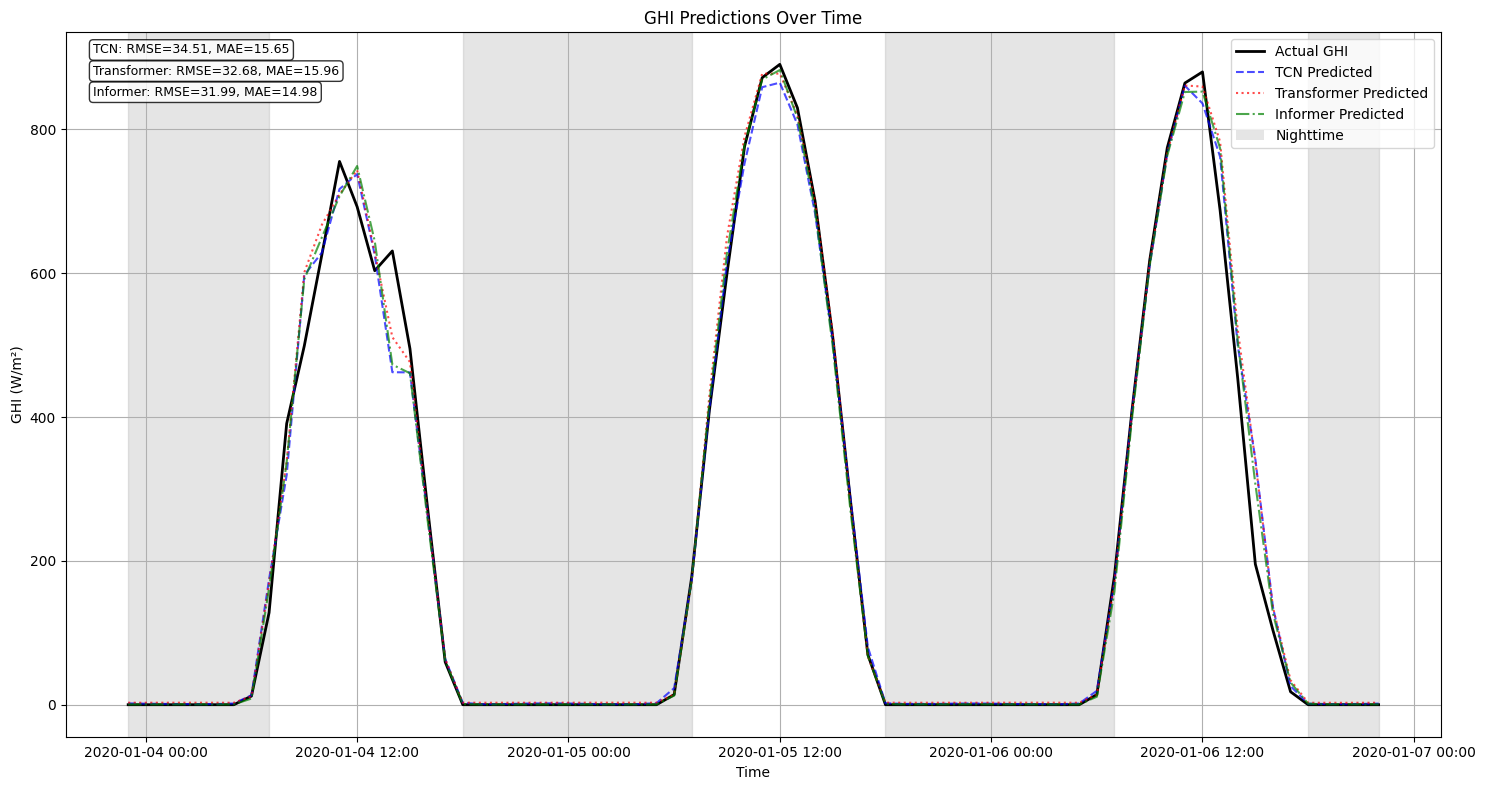

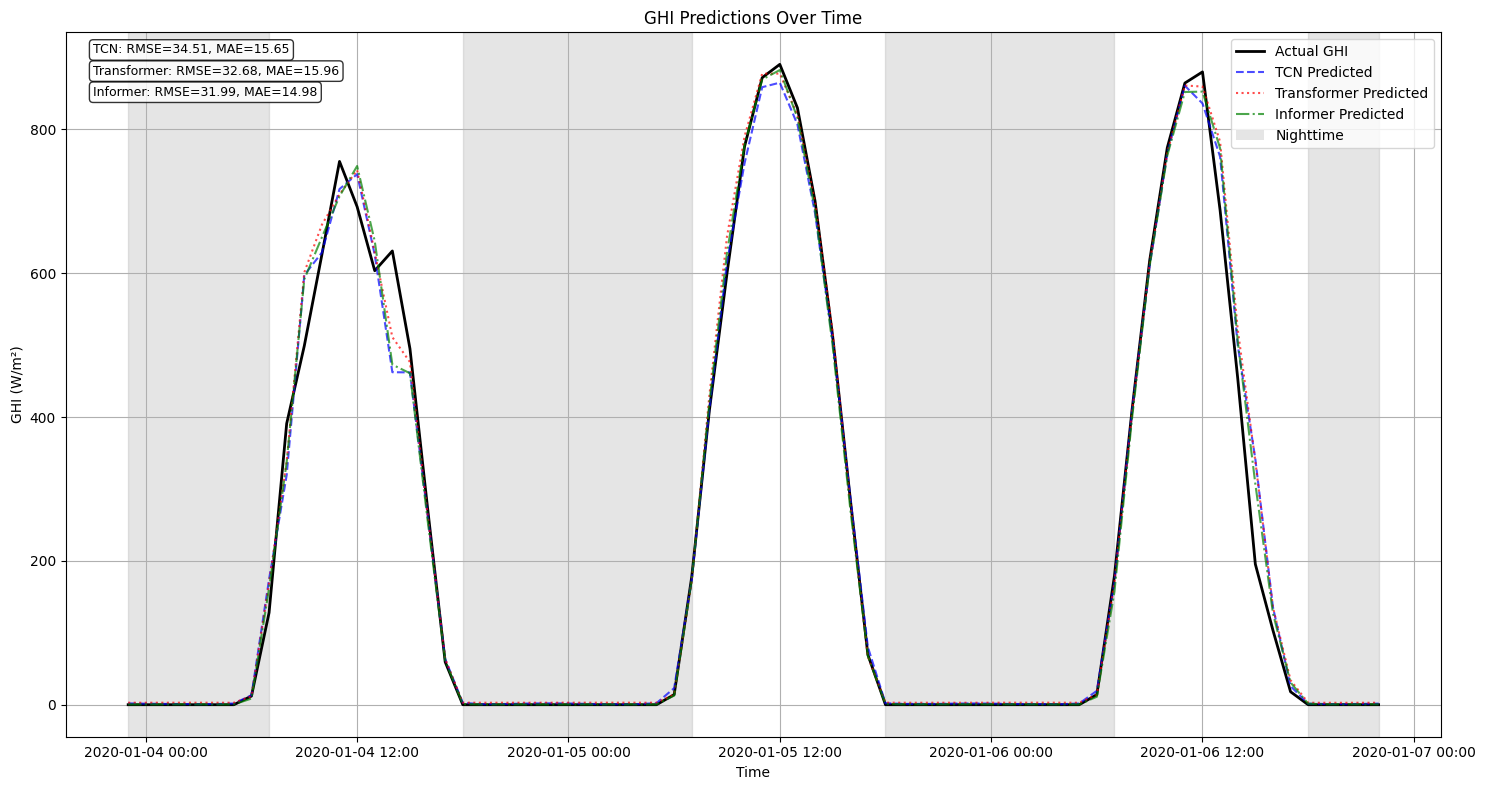

In [16]:
# Plot time series predictions
plot_predictions_over_time(
    models=[tcn_model, transformer_model, informer_model],
    model_names=['TCN', 'Transformer', 'Informer'],
    data_loader=test_loader,
    target_scaler=scalers[f'{TARGET_VARIABLE}_scaler'],
    num_samples=72,
    start_idx=40
)

